### loading necessary imports

In [14]:
# =====================================================================
#  CORE LIBRARIES
# =====================================================================
import os
import gc
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib

warnings.filterwarnings('ignore')

# =====================================================================
#  VISUALIZATION
# =====================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score, precision_score,
    recall_score, confusion_matrix, brier_score_loss,
    roc_curve, precision_recall_curve, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)

# =====================================================================
#  MODELING & OPTIMIZATION
# =====================================================================
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, train_test_split
)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

# Gradient boosting frameworks
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.ERROR)

### loading the data

In [15]:
# ==================== MAIN EXECUTION ====================

# Find project root
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

# Paths
PROCESSED_DATA_PATH = PROJECT_ROOT / 'data' / 'processed' / 'processed_data.parquet'
ARTIFACTS_PATH = PROJECT_ROOT / 'artifacts' / 'split data sets'

print("="*60)
print("DATA SPLIT & SAVE")
print("="*60)
print(f"✓ Project root: {PROJECT_ROOT}")
print(f"✓ processed data: {PROCESSED_DATA_PATH}")
print(f"✓ Artifacts: {ARTIFACTS_PATH}")
print("="*60)

# Check file exists
if not PROCESSED_DATA_PATH.exists():
    print(f"\n❌ ERROR: processed data not found at: {PROCESSED_DATA_PATH}")
    exit(1)

# Load processed data
print("\n📂 Loading processed data...")
df = pd.read_parquet(PROCESSED_DATA_PATH)
print(f"✓ Loaded: {df.shape}")

# Target label mapping
target_labels = {0: 'No Disease', 1: 'Disease'}

print(f"\n📊 Target Distribution:")
target_dist = df['target'].map(target_labels).value_counts()
for label, count in target_dist.items():
    pct = (count / len(df)) * 100
    print(f"  {label:12s}: {count:>6,} ({pct:>5.2f}%)")

# Split
print(f"\n📊 Splitting data (70/30)...")
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"✓ Train: {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)")
print(f"✓ Test:  {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)")

# Create directory if not exists
ARTIFACTS_PATH.mkdir(parents=True, exist_ok=True)

# Save (always overwrite)
print(f"\n💾 Saving splits...")
X_train.to_parquet(ARTIFACTS_PATH / 'X_train.parquet', index=False)
X_test.to_parquet(ARTIFACTS_PATH / 'X_test.parquet', index=False)
y_train.to_frame().to_parquet(ARTIFACTS_PATH / 'y_train.parquet', index=False)
y_test.to_frame().to_parquet(ARTIFACTS_PATH / 'y_test.parquet', index=False)

# Summary
print("\n" + "="*60)
print("✓ SPLIT & SAVE COMPLETE")
print("="*60)
print(f"Shape: Train {X_train.shape} | Test {X_test.shape}")

# Train target
print(f"\nTrain Target Distribution:")
train_target_dist = y_train.map(target_labels).value_counts()
for label, count in train_target_dist.items():
    pct = (count / len(y_train)) * 100
    print(f"  {label:12s}: {count:>6,} ({pct:>5.2f}%)")

# Test target
print(f"\nTest Target Distribution:")
test_target_dist = y_test.map(target_labels).value_counts()
for label, count in test_target_dist.items():
    pct = (count / len(y_test)) * 100
    print(f"  {label:12s}: {count:>6,} ({pct:>5.2f}%)")

print(f"\nSaved to: {ARTIFACTS_PATH}")
print(f"  - X_train.parquet")
print(f"  - X_test.parquet")
print(f"  - y_train.parquet")
print(f"  - y_test.parquet")
print("="*60)

DATA SPLIT & SAVE
✓ Project root: p:\projects\heart_disease_prediction
✓ processed data: p:\projects\heart_disease_prediction\data\processed\processed_data.parquet
✓ Artifacts: p:\projects\heart_disease_prediction\artifacts\split data sets

📂 Loading processed data...
✓ Loaded: (69976, 15)

📊 Target Distribution:
  No Disease  : 35,004 (50.02%)
  Disease     : 34,972 (49.98%)

📊 Splitting data (70/30)...
✓ Train: 48,983 (70.0%)
✓ Test:  20,993 (30.0%)

💾 Saving splits...

✓ SPLIT & SAVE COMPLETE
Shape: Train (48983, 14) | Test (20993, 14)

Train Target Distribution:
  No Disease  : 24,503 (50.02%)
  Disease     : 24,480 (49.98%)

Test Target Distribution:
  No Disease  : 10,501 (50.02%)
  Disease     : 10,492 (49.98%)

Saved to: p:\projects\heart_disease_prediction\artifacts\split data sets
  - X_train.parquet
  - X_test.parquet
  - y_train.parquet
  - y_test.parquet


### Base model selection

In [16]:
# ============================================================================
# LOAD DATA
# ============================================================================
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts' / 'split data sets'

# Load 70% train and 30% test
X_train = pd.read_parquet(ARTIFACTS_DIR / 'X_train.parquet')
X_test_full = pd.read_parquet(ARTIFACTS_DIR / 'X_test.parquet')
y_train = pd.read_parquet(ARTIFACTS_DIR / 'y_train.parquet').iloc[:, 0]
y_test_full = pd.read_parquet(ARTIFACTS_DIR / 'y_test.parquet').iloc[:, 0]

print(f"✓ Data loaded: Train {X_train.shape}, Test {X_test_full.shape}")

# Split test data into validation (10%), calibration (10%), and test (10%)
X_temp, X_val, y_temp, y_val = train_test_split(
    X_test_full, y_test_full, test_size=1/3, stratify=y_test_full, random_state=42
)
X_cal, X_test, y_cal, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"  → Validation:  {X_val.shape} (10%)")
print(f"  → Calibration: {X_cal.shape} (10%)")
print(f"  → Test:        {X_test.shape} (10%)\n")

# ============================================================================
# MODELS
# ============================================================================
models = {
    'XGBoost': XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        tree_method='gpu_hist', gpu_id=0,
        random_state=42, verbosity=0
    ),
    
    'LightGBM': LGBMClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        num_leaves=15, subsample=0.8, colsample_bytree=0.8,
        random_state=42, verbose=-1, n_jobs=-1
    ),
    
    'CatBoost': CatBoostClassifier(
        iterations=200, depth=4, learning_rate=0.05,
        l2_leaf_reg=3, random_strength=1,
        bagging_temperature=1, border_count=128,
        random_seed=42, verbose=False
    ),
    
    'RandomForest': RandomForestClassifier(
        n_estimators=200, max_depth=6, min_samples_split=20,
        max_features='sqrt', class_weight='balanced',
        random_state=42, n_jobs=-1
    ),
    
    'ExtraTrees': ExtraTreesClassifier(
        n_estimators=200, max_depth=8, min_samples_split=15,
        max_features='sqrt', class_weight='balanced',
        random_state=42, n_jobs=-1
    ),
    
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        subsample=0.8, max_features='sqrt', random_state=42
    ),
    
    'LogisticRegression': LogisticRegression(
        C=1.0, penalty='l2', solver='liblinear',
        class_weight='balanced', random_state=42
    ),
    
    'GaussianNB': GaussianNB()
}

# ============================================================================
# EVALUATE
# ============================================================================
def evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                                scoring='roc_auc', n_jobs=-1)
    
    train_auc = roc_auc_score(y_train, y_train_proba)
    val_auc = roc_auc_score(y_val, y_val_proba)
    
    return {
        'Model': '',
        'Val_AUC': val_auc,
        'Accuracy': accuracy_score(y_val, y_val_pred),
        'Precision': precision_score(y_val, y_val_pred, zero_division=0),
        'Recall': recall_score(y_val, y_val_pred, zero_division=0),
        'F1': f1_score(y_val, y_val_pred, zero_division=0),
        'Train_AUC': train_auc,
        'CV_AUC_Mean': cv_scores.mean(),
        'CV_AUC_Std': cv_scores.std(),
        'Overfitting_Gap': train_auc - val_auc
    }

# ============================================================================
# RUN EVALUATION
# ============================================================================
print("Evaluating models...\n")

results = []
for name, model in models.items():
    try:
        metrics = evaluate_model(model, X_train, X_val, y_train, y_val)
        metrics['Model'] = name
        results.append(metrics)
        print(f"✓ {name}")
    except Exception as e:
        print(f"✗ {name}: {str(e)[:50]}")

# ============================================================================
# RESULTS
# ============================================================================
df_baseline_metrics = pd.DataFrame(results)
df_baseline_metrics = df_baseline_metrics.sort_values('Val_AUC', ascending=False).reset_index(drop=True)
print(df_baseline_metrics.to_string(index=False))

✓ Data loaded: Train (48983, 14), Test (20993, 14)
  → Validation:  (6998, 14) (10%)
  → Calibration: (6997, 14) (10%)
  → Test:        (6998, 14) (10%)

Evaluating models...

✓ XGBoost
✓ LightGBM
✓ CatBoost
✓ RandomForest
✓ ExtraTrees
✓ GradientBoosting
✓ LogisticRegression
✓ GaussianNB
             Model  Val_AUC  Accuracy  Precision   Recall       F1  Train_AUC  CV_AUC_Mean  CV_AUC_Std  Overfitting_Gap
  GradientBoosting 0.803154  0.732209   0.752411 0.691736 0.720799   0.812932     0.802517    0.005069         0.009777
           XGBoost 0.802593  0.733067   0.752402 0.694309 0.722189   0.813258     0.802824    0.005092         0.010665
          LightGBM 0.802532  0.732781   0.751780 0.694595 0.722057   0.812876     0.802731    0.005223         0.010343
          CatBoost 0.802290  0.732352   0.752488 0.692022 0.720989   0.805907     0.802470    0.004891         0.003617
      RandomForest 0.797579  0.730494   0.751483 0.688304 0.718507   0.805160     0.799320    0.004867         

### Model Selection and Calibration

In [5]:
"""
Heart Disease Training Pipeline - Production Model
Auto Model Selection + 3 Risk Groups + BCa Bootstrap
"""

import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import warnings
from typing import Dict, Any, Tuple, Optional, Callable

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, brier_score_loss, roc_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

import optuna
from optuna.samplers import TPESampler
from scipy import stats
from joblib import Parallel, delayed
from tqdm import tqdm

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.ERROR)

try:
    from betacal import BetaCalibration
    BETACAL_AVAILABLE = True
except ImportError:
    BETACAL_AVAILABLE = False

# Configuration
CONFIG: Dict[str, Any] = {
    'random_state': 42,
    'n_trials': 50,
    'n_estimators': 1500,
    'cat_iterations': 400,
    'n_bootstraps': 1000,
    'min_sensitivity': 0.80,
    'cart_max_depth': 2,
    'cart_min_samples_leaf': 500,
    'cart_min_impurity_decrease': 0.01,
    'calibration_methods': ['isotonic'] + (['beta'] if BETACAL_AVAILABLE else []),
}

RANDOM_STATE = CONFIG['random_state']
np.random.seed(RANDOM_STATE)

def find_optimal_threshold(y_true: np.ndarray, y_proba: np.ndarray, min_sensitivity: float = 0.80) -> Dict[str, float]:
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    valid_mask = tpr >= min_sensitivity
    valid_indices = np.where(valid_mask)[0]
    
    if len(valid_indices) == 0:
        youden_j = tpr - fpr
        best_idx = np.argmax(youden_j)
    else:
        youden_j = tpr[valid_indices] - fpr[valid_indices]
        best_j_idx = np.argmax(youden_j)
        best_idx = valid_indices[best_j_idx]
    
    threshold = float(thresholds[best_idx])
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    sensitivity = float(tp / (tp + fn)) if (tp + fn) > 0 else 0.0
    specificity = float(tn / (tn + fp)) if (tn + fp) > 0 else 0.0
    fnr = 1 - sensitivity
    
    return {
        'threshold': threshold,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'fnr': fnr,
        'ppv': float(tp / (tp + fp)) if (tp + fp) > 0 else 0.0,
        'npv': float(tn / (tn + fn)) if (tn + fn) > 0 else 0.0,
        'f1': float(2 * tp / (2 * tp + fp + fn)) if (2 * tp + fp + fn) > 0 else 0.0,
        'accuracy': float((tp + tn) / (tp + tn + fp + fn)),
        'youden_j': sensitivity + specificity - 1,
        'constraint_met': fnr <= (1 - min_sensitivity)
    }

def calculate_bca_ci(y_true: np.ndarray, y_proba: np.ndarray, threshold: float, metric_fn: Callable, n_bootstraps: int = 1000, alpha: float = 0.05, n_jobs: int = -1) -> Dict[str, float]:
    """BCa Bootstrap Confidence Interval - FULLY FIXED VERSION"""
    n = len(y_true)
    try:
        theta_hat = metric_fn(y_true, y_proba, threshold)
    except Exception:
        return {'mean': np.nan, 'ci_lower': np.nan, 'ci_upper': np.nan}
    
    def bootstrap_sample(seed: int):
        try:
            idx = resample(range(n), n_samples=n, random_state=seed, stratify=y_true)
            return metric_fn(y_true[idx], y_proba[idx], threshold)
        except Exception:
            return None
    
    theta_boot = Parallel(n_jobs=n_jobs)(delayed(bootstrap_sample)(i) for i in range(n_bootstraps))
    theta_boot = [x for x in theta_boot if x is not None]
    
    if len(theta_boot) < 100:
        return {'mean': theta_hat, 'ci_lower': np.nan, 'ci_upper': np.nan}
    
    theta_boot = np.array(theta_boot)
    
    # Bias correction
    p_less = np.clip(np.mean(theta_boot < theta_hat), 0.001, 0.999)
    z0 = stats.norm.ppf(p_less)
    
    # Acceleration
    theta_mean = np.mean(theta_boot)
    diff = theta_boot - theta_mean
    numerator = np.sum(diff ** 3)
    denominator = 6 * (np.sum(diff ** 2) ** 1.5)
    a = np.clip(numerator / denominator if denominator != 0 else 0.0, -0.5, 0.5)
    
    # Z-scores
    z_alpha = stats.norm.ppf(alpha / 2)
    z_1_alpha = stats.norm.ppf(1 - alpha / 2)
    
    # Adjusted percentiles
    denom_lower = max(1 - a * (z0 + z_alpha), 0.001)
    denom_upper = max(1 - a * (z0 + z_1_alpha), 0.001)
    
    p_lower = stats.norm.cdf(z0 + (z0 + z_alpha) / denom_lower)
    p_upper = stats.norm.cdf(z0 + (z0 + z_1_alpha) / denom_upper)
    
    # ✅ CRITICAL FIX: Ensure valid percentile range [0.01, 99.99]
    p_lower = float(np.clip(p_lower * 100, 0.01, 99.99))
    p_upper = float(np.clip(p_upper * 100, 0.01, 99.99))
    
    # Compute CI
    try:
        ci_lower = np.percentile(theta_boot, p_lower)
        ci_upper = np.percentile(theta_boot, p_upper)
    except Exception:
        # Fallback to simple percentile method
        ci_lower = np.percentile(theta_boot, 2.5)
        ci_upper = np.percentile(theta_boot, 97.5)
    
    return {'mean': float(theta_hat), 'ci_lower': float(ci_lower), 'ci_upper': float(ci_upper)}

def bootstrap_bca_ci(y_true: np.ndarray, y_proba: np.ndarray, threshold: float, n_bootstraps: int = 1000, n_jobs: int = -1) -> Dict:
    def auc_fn(y_t, y_p, t): 
        return roc_auc_score(y_t, y_p)
    
    def sens_fn(y_t, y_p, t):
        y_pred = (y_p >= t).astype(int)
        try:
            tn, fp, fn, tp = confusion_matrix(y_t, y_pred).ravel()
            return tp / (tp + fn) if (tp + fn) > 0 else np.nan
        except:
            return np.nan
    
    def spec_fn(y_t, y_p, t):
        y_pred = (y_p >= t).astype(int)
        try:
            tn, fp, fn, tp = confusion_matrix(y_t, y_pred).ravel()
            return tn / (tn + fp) if (tn + fp) > 0 else np.nan
        except:
            return np.nan
    
    def fnr_fn(y_t, y_p, t): 
        return 1 - sens_fn(y_t, y_p, t)
    
    metrics = {'AUC': auc_fn, 'SENSITIVITY': sens_fn, 'SPECIFICITY': spec_fn, 'FNR': fnr_fn}
    results = {}
    for metric_name, metric_fn in tqdm(metrics.items(), desc="  Progress", leave=False):
        results[metric_name] = calculate_bca_ci(y_true, y_proba, threshold, metric_fn, n_bootstraps, n_jobs)
    
    return results

def create_data_driven_cart_stratification(X: pd.DataFrame, y_true: np.ndarray, y_proba: np.ndarray, config: Dict) -> Tuple[DecisionTreeClassifier, Dict, Dict]:
    """Create CART-based risk stratification. Returns: cart_model, leaf_to_risk, risk_statistics"""
    X_cart = pd.DataFrame({'Predicted_Risk': y_proba})
    cart = DecisionTreeClassifier(
        max_depth=2, 
        min_samples_leaf=config['cart_min_samples_leaf'], 
        min_samples_split=config['cart_min_samples_leaf'] * 2, 
        min_impurity_decrease=config.get('cart_min_impurity_decrease', 0.01), 
        class_weight='balanced', 
        random_state=config['random_state']
    )
    cart.fit(X_cart, y_true)
    leaves = cart.apply(X_cart)
    unique_leaves = np.unique(leaves)
    
    leaf_stats = []
    for leaf in unique_leaves:
        mask = leaves == leaf
        leaf_stats.append({
            'leaf': leaf, 
            'n': mask.sum(), 
            'prevalence': y_true[mask].mean(), 
            'mean_risk': y_proba[mask].mean()
        })
    
    leaf_stats.sort(key=lambda x: x['prevalence'])
    risk_names = ['Low', 'Moderate', 'High']
    leaf_to_risk = {}
    for i, stat in enumerate(leaf_stats):
        leaf_to_risk[stat['leaf']] = risk_names[min(i, len(risk_names)-1)]
    
    risk_statistics = {}
    for i, stat in enumerate(leaf_stats):
        risk = risk_names[min(i, len(risk_names)-1)]
        mask = np.array([leaf_to_risk[leaf] == risk for leaf in leaves])
        n = mask.sum()
        pct = n / len(y_true) * 100
        prevalence = y_true[mask].mean()
        mean_risk = y_proba[mask].mean()
        
        action = "Reassure" if prevalence < 0.20 else "Monitor" if prevalence < 0.40 else "Intervention"
        
        risk_statistics[risk] = {
            'n': int(n), 
            'percentage': float(pct), 
            'disease_prevalence': float(prevalence * 100), 
            'mean_risk_score': float(mean_risk), 
            'clinical_action': action
        }
    
    return cart, leaf_to_risk, risk_statistics

def train_calibrator(model, X_train: pd.DataFrame, y_train: np.ndarray, X_test: pd.DataFrame, method: str = 'isotonic') -> Tuple[np.ndarray, Optional[Any]]:
    y_test_base = model.predict_proba(X_test)[:, 1]
    
    if method == 'isotonic':
        try:
            y_train_base = model.predict_proba(X_train)[:, 1]
            iso_cal = IsotonicRegression(out_of_bounds='clip')
            iso_cal.fit(y_train_base, y_train)
            return iso_cal.predict(y_test_base), iso_cal
        except Exception as e:
            print(f"  ⚠️  Isotonic failed: {e}")
            return y_test_base, None
    
    elif method == 'beta' and BETACAL_AVAILABLE:
        try:
            y_train_base = model.predict_proba(X_train)[:, 1]
            beta_cal = BetaCalibration(parameters="abm")
            beta_cal.fit(y_train_base, y_train)
            return beta_cal.predict(y_test_base), beta_cal
        except Exception as e:
            print(f"  ⚠️  Beta failed: {e}")
            return y_test_base, None
    
    return y_test_base, None

def optimize_model(model_type: str, X_train: pd.DataFrame, y_train: np.ndarray, config: Dict) -> Dict[str, Any]:
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=config['random_state'])
    
    def objective(trial):
        if model_type == 'xgb':
            params = {
                'n_estimators': config['n_estimators'], 
                'max_depth': trial.suggest_int('max_depth', 3, 9), 
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True), 
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 15), 
                'subsample': trial.suggest_float('subsample', 0.6, 1.0), 
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), 
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 5.0), 
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 5.0), 
                'gamma': trial.suggest_float('gamma', 0, 1.0), 
                'tree_method': 'gpu_hist', 
                'gpu_id': 0, 
                'random_state': config['random_state'], 
                'verbosity': 0
            }
            model = XGBClassifier(**params)
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        elif model_type == 'lgbm':
            params = {
                'n_estimators': config['n_estimators'], 
                'max_depth': trial.suggest_int('max_depth', 4, 7), 
                'num_leaves': trial.suggest_int('num_leaves', 20, 60), 
                'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.1, log=True), 
                'min_child_samples': trial.suggest_int('min_child_samples', 10, 40), 
                'subsample': trial.suggest_float('subsample', 0.7, 1.0), 
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0), 
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 3.0), 
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 3.0), 
                'device': 'cpu', 
                'random_state': config['random_state'], 
                'verbosity': -1
            }
            model = LGBMClassifier(**params)
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(50, verbose=False)])
        
        else:
            params = {
                'iterations': config['cat_iterations'], 
                'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.12, log=True), 
                'depth': trial.suggest_int('depth', 4, 7), 
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 8), 
                'random_strength': trial.suggest_float('random_strength', 0, 1.5), 
                'task_type': 'CPU', 
                'random_seed': config['random_state'], 
                'verbose': False
            }
            model = CatBoostClassifier(**params)
            model.fit(Pool(X_tr, y_tr), eval_set=Pool(X_val, y_val), early_stopping_rounds=40, verbose=False)
        
        return roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=config['random_state']))
    study.optimize(objective, n_trials=config['n_trials'], show_progress_bar=True)
    
    return study.best_params

def get_project_root() -> Path:
    current = Path.cwd().resolve()
    max_depth = 5
    depth = 0
    
    while depth < max_depth and current != current.parent:
        if (current / 'artifacts').exists():
            return current
        current = current.parent
        depth += 1
    
    raise RuntimeError("Could not find project root with 'artifacts' directory")

def main() -> Dict[str, Any]:
    print("\n" + "="*80)
    print("HEART DISEASE PREDICTION - PRODUCTION MODEL TRAINING")
    print("="*80)
    
    PROJECT_ROOT = get_project_root()
    SPLIT_DIR = PROJECT_ROOT / 'artifacts' / 'split data sets'
    MODEL_DIR = PROJECT_ROOT / 'artifacts' / 'model'
    MODEL_DIR.mkdir(parents=True, exist_ok=True)
    
    print("[1/8] Loading data...")
    X_train = pd.read_parquet(SPLIT_DIR / 'X_train.parquet')
    X_test_full = pd.read_parquet(SPLIT_DIR / 'X_test.parquet')
    y_train = pd.read_parquet(SPLIT_DIR / 'y_train.parquet').iloc[:, 0].values
    y_test_full = pd.read_parquet(SPLIT_DIR / 'y_test.parquet').iloc[:, 0].values
    
    X_cal, X_test, y_cal, y_test = train_test_split(X_test_full, y_test_full, test_size=0.5, stratify=y_test_full, random_state=RANDOM_STATE)
    
    print(f"  ✅ Train: {len(X_train):,} | Cal: {len(X_cal):,} | Test: {len(X_test):,}")
    
    print("[2/8] Hyperparameter optimization...")
    best_params = {model_type: optimize_model(model_type, X_train, y_train, CONFIG) for model_type in ['xgb', 'lgbm', 'cat']}
    
    print("[3/8] Training models...")
    models = {}
    xgb_params = {**best_params['xgb'], 'n_estimators': CONFIG['n_estimators'], 'tree_method': 'gpu_hist', 'gpu_id': 0, 'random_state': RANDOM_STATE, 'verbosity': 0}
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_train, y_train, eval_set=[(X_cal, y_cal)], early_stopping_rounds=50, verbose=False)
    models['XGBoost'] = {'model': xgb_model, 'params': best_params['xgb']}
    print("  ✅ XGBoost (GPU)")
    
    lgbm_params = {**best_params['lgbm'], 'n_estimators': CONFIG['n_estimators'], 'device': 'cpu', 'random_state': RANDOM_STATE, 'verbosity': -1}
    lgbm_model = LGBMClassifier(**lgbm_params)
    lgbm_model.fit(X_train, y_train, eval_set=[(X_cal, y_cal)], callbacks=[lgb.early_stopping(50, verbose=False)])
    models['LightGBM'] = {'model': lgbm_model, 'params': best_params['lgbm']}
    print("  ✅ LightGBM (CPU)")
    
    cat_params = {**best_params['cat'], 'iterations': CONFIG['cat_iterations'], 'task_type': 'CPU', 'random_seed': RANDOM_STATE, 'verbose': False}
    cat_model = CatBoostClassifier(**cat_params)
    cat_model.fit(X_train, y_train, eval_set=(X_cal, y_cal), early_stopping_rounds=40, verbose=False)
    models['CatBoost'] = {'model': cat_model, 'params': best_params['cat']}
    print("  ✅ CatBoost (CPU)")
    
    print("[4/8] Calibration selection...")
    X_cal_train, X_cal_val, y_cal_train, y_cal_val = train_test_split(X_cal, y_cal, test_size=0.5, stratify=y_cal, random_state=RANDOM_STATE)
    
    best_brier = float('inf')
    best_model_name = None
    best_cal_method = None
    
    for model_name, model_info in models.items():
        for cal_method in CONFIG['calibration_methods']:
            y_cal_val_proba, _ = train_calibrator(model_info['model'], X_cal_train, y_cal_train, X_cal_val, cal_method)
            brier = brier_score_loss(y_cal_val, y_cal_val_proba)
            
            if brier < best_brier:
                best_brier = brier
                best_model_name = model_name
                best_cal_method = cal_method
    
    print(f"  🏆 Selected: {best_model_name} + {best_cal_method}")
    print(f"  ✅ Calibration Brier: {best_brier:.4f}")
    
    best_model = models[best_model_name]['model']
    y_test_proba, final_calibrator = train_calibrator(best_model, X_cal, y_cal, X_test, best_cal_method)
    
    print("[5/8] Threshold optimization...")
    y_cal_proba, _ = train_calibrator(best_model, X_cal, y_cal, X_cal, best_cal_method)
    threshold_result = find_optimal_threshold(y_cal, y_cal_proba, CONFIG['min_sensitivity'])
    threshold = threshold_result['threshold']
    
    print(f"  ✅ Threshold: {threshold:.4f}")
    
    print("[6/8] Test evaluation...")
    y_pred = (y_test_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    performance = {
        'auc': roc_auc_score(y_test, y_test_proba),
        'brier': brier_score_loss(y_test, y_test_proba),
        'sensitivity': float(tp / (tp + fn)),
        'specificity': float(tn / (tn + fp)),
        'fnr': float(fn / (tp + fn))
    }
    
    print(f"  AUC: {performance['auc']:.4f}")
    print(f"  Brier: {performance['brier']:.4f}")
    
    print("[7/8] BCa Bootstrap CIs...")
    ci_results = bootstrap_bca_ci(y_test, y_test_proba, threshold, CONFIG['n_bootstraps'])
    
    print("[8/8] CART risk stratification...")
    cart_model, leaf_to_risk, risk_stats = create_data_driven_cart_stratification(X_test, y_test, y_test_proba, CONFIG)
    
    print("\nSaving model package...")
    package = {
        'model_type': best_model_name,
        'base_model': best_model,
        'calibrator': final_calibrator,
        'calibration_method': best_cal_method,
        'cart_model': cart_model,
        'leaf_to_risk': leaf_to_risk,
        'threshold': threshold,
        'test_performance': performance,
        'confidence_intervals': ci_results,
        'risk_statistics': risk_stats,
        'config': CONFIG
    }
    
    joblib.dump(package, MODEL_DIR / 'model_package.pkl', compress=3)
    print("  ✅ Saved: model_package.pkl")
    
    print("\n" + "="*80)
    print("TRAINING COMPLETE")
    print("="*80)
    print(f"\nModel: {best_model_name}")
    print(f"Calibration: {best_cal_method.upper()}")
    print(f"Risk System: CART ({len(risk_stats)} groups)")
    
    print(f"\nTest Performance (with BCa CIs):")
    for metric, result in ci_results.items():
        ci_str = "[NaN, NaN]" if np.isnan(result['ci_lower']) else f"[{result['ci_lower']:.3f}, {result['ci_upper']:.3f}]"
        print(f"  {metric}: {result['mean']:.3f} {ci_str}")
    
    print(f"\nRisk Groups:")
    for risk, stats in risk_stats.items():
        print(f"  {risk}: {stats['n']:,} ({stats['percentage']:.1f}%) - {stats['clinical_action']}")
    
    print("\n" + "="*80 + "\n")
    
    return package

if __name__ == "__main__":
    try:
        package = main()
        print("✅ Success! Model ready.\n")
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()
        raise


HEART DISEASE PREDICTION - PRODUCTION MODEL TRAINING
[1/8] Loading data...
  ✅ Train: 48,983 | Cal: 10,496 | Test: 10,497
[2/8] Hyperparameter optimization...


Best trial: 22. Best value: 0.799664: 100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


[3/8] Training models...
  ✅ XGBoost (GPU)
  ✅ LightGBM (CPU)
  ✅ CatBoost (CPU)
[4/8] Calibration selection...
  🏆 Selected: CatBoost + beta
  ✅ Calibration Brier: 0.1789
[5/8] Threshold optimization...
  ✅ Threshold: 0.3818
[6/8] Test evaluation...
  AUC: 0.8016
  Brier: 0.1806
[7/8] BCa Bootstrap CIs...


[8/8] CART risk stratification...

Saving model package...
  ✅ Saved: model_package.pkl

TRAINING COMPLETE

Model: CatBoost
Calibration: BETA
Risk System: CART (3 groups)

Test Performance (with BCa CIs):
  AUC: 0.802 [0.794, 0.810]
  SENSITIVITY: 0.805 [0.794, 0.816]
  SPECIFICITY: 0.639 [0.625, 0.652]
  FNR: 0.195 [0.184, 0.206]

Risk Groups:
  Low: 3,212 (30.6%) - Reassure
  Moderate: 2,839 (27.0%) - Intervention
  High: 4,446 (42.4%) - Intervention


✅ Success! Model ready.



### Evaluation Metrics Summary


MODEL EVALUATION - FINAL TEST SET (15%)

✓ Model: CatBoost + Beta
✓ Threshold: 0.3818

✓ Data Split: Train 70% | Cal 15% | Test 15%
✓ Test: 10,497 samples | Disease: 50.0%

✓ Bootstrap evaluation (n=1000)...
  AUC:   0.8016 [0.7930, 0.8098]
  Brier: 0.1806 [0.1768, 0.1845]
  Sens: 0.805 | Spec: 0.639 | PPV: 0.690 | NPV: 0.766

✓ Generating high-resolution dashboard...

✅ Saved: 01_model_evaluation_dashboard.png (300 DPI)


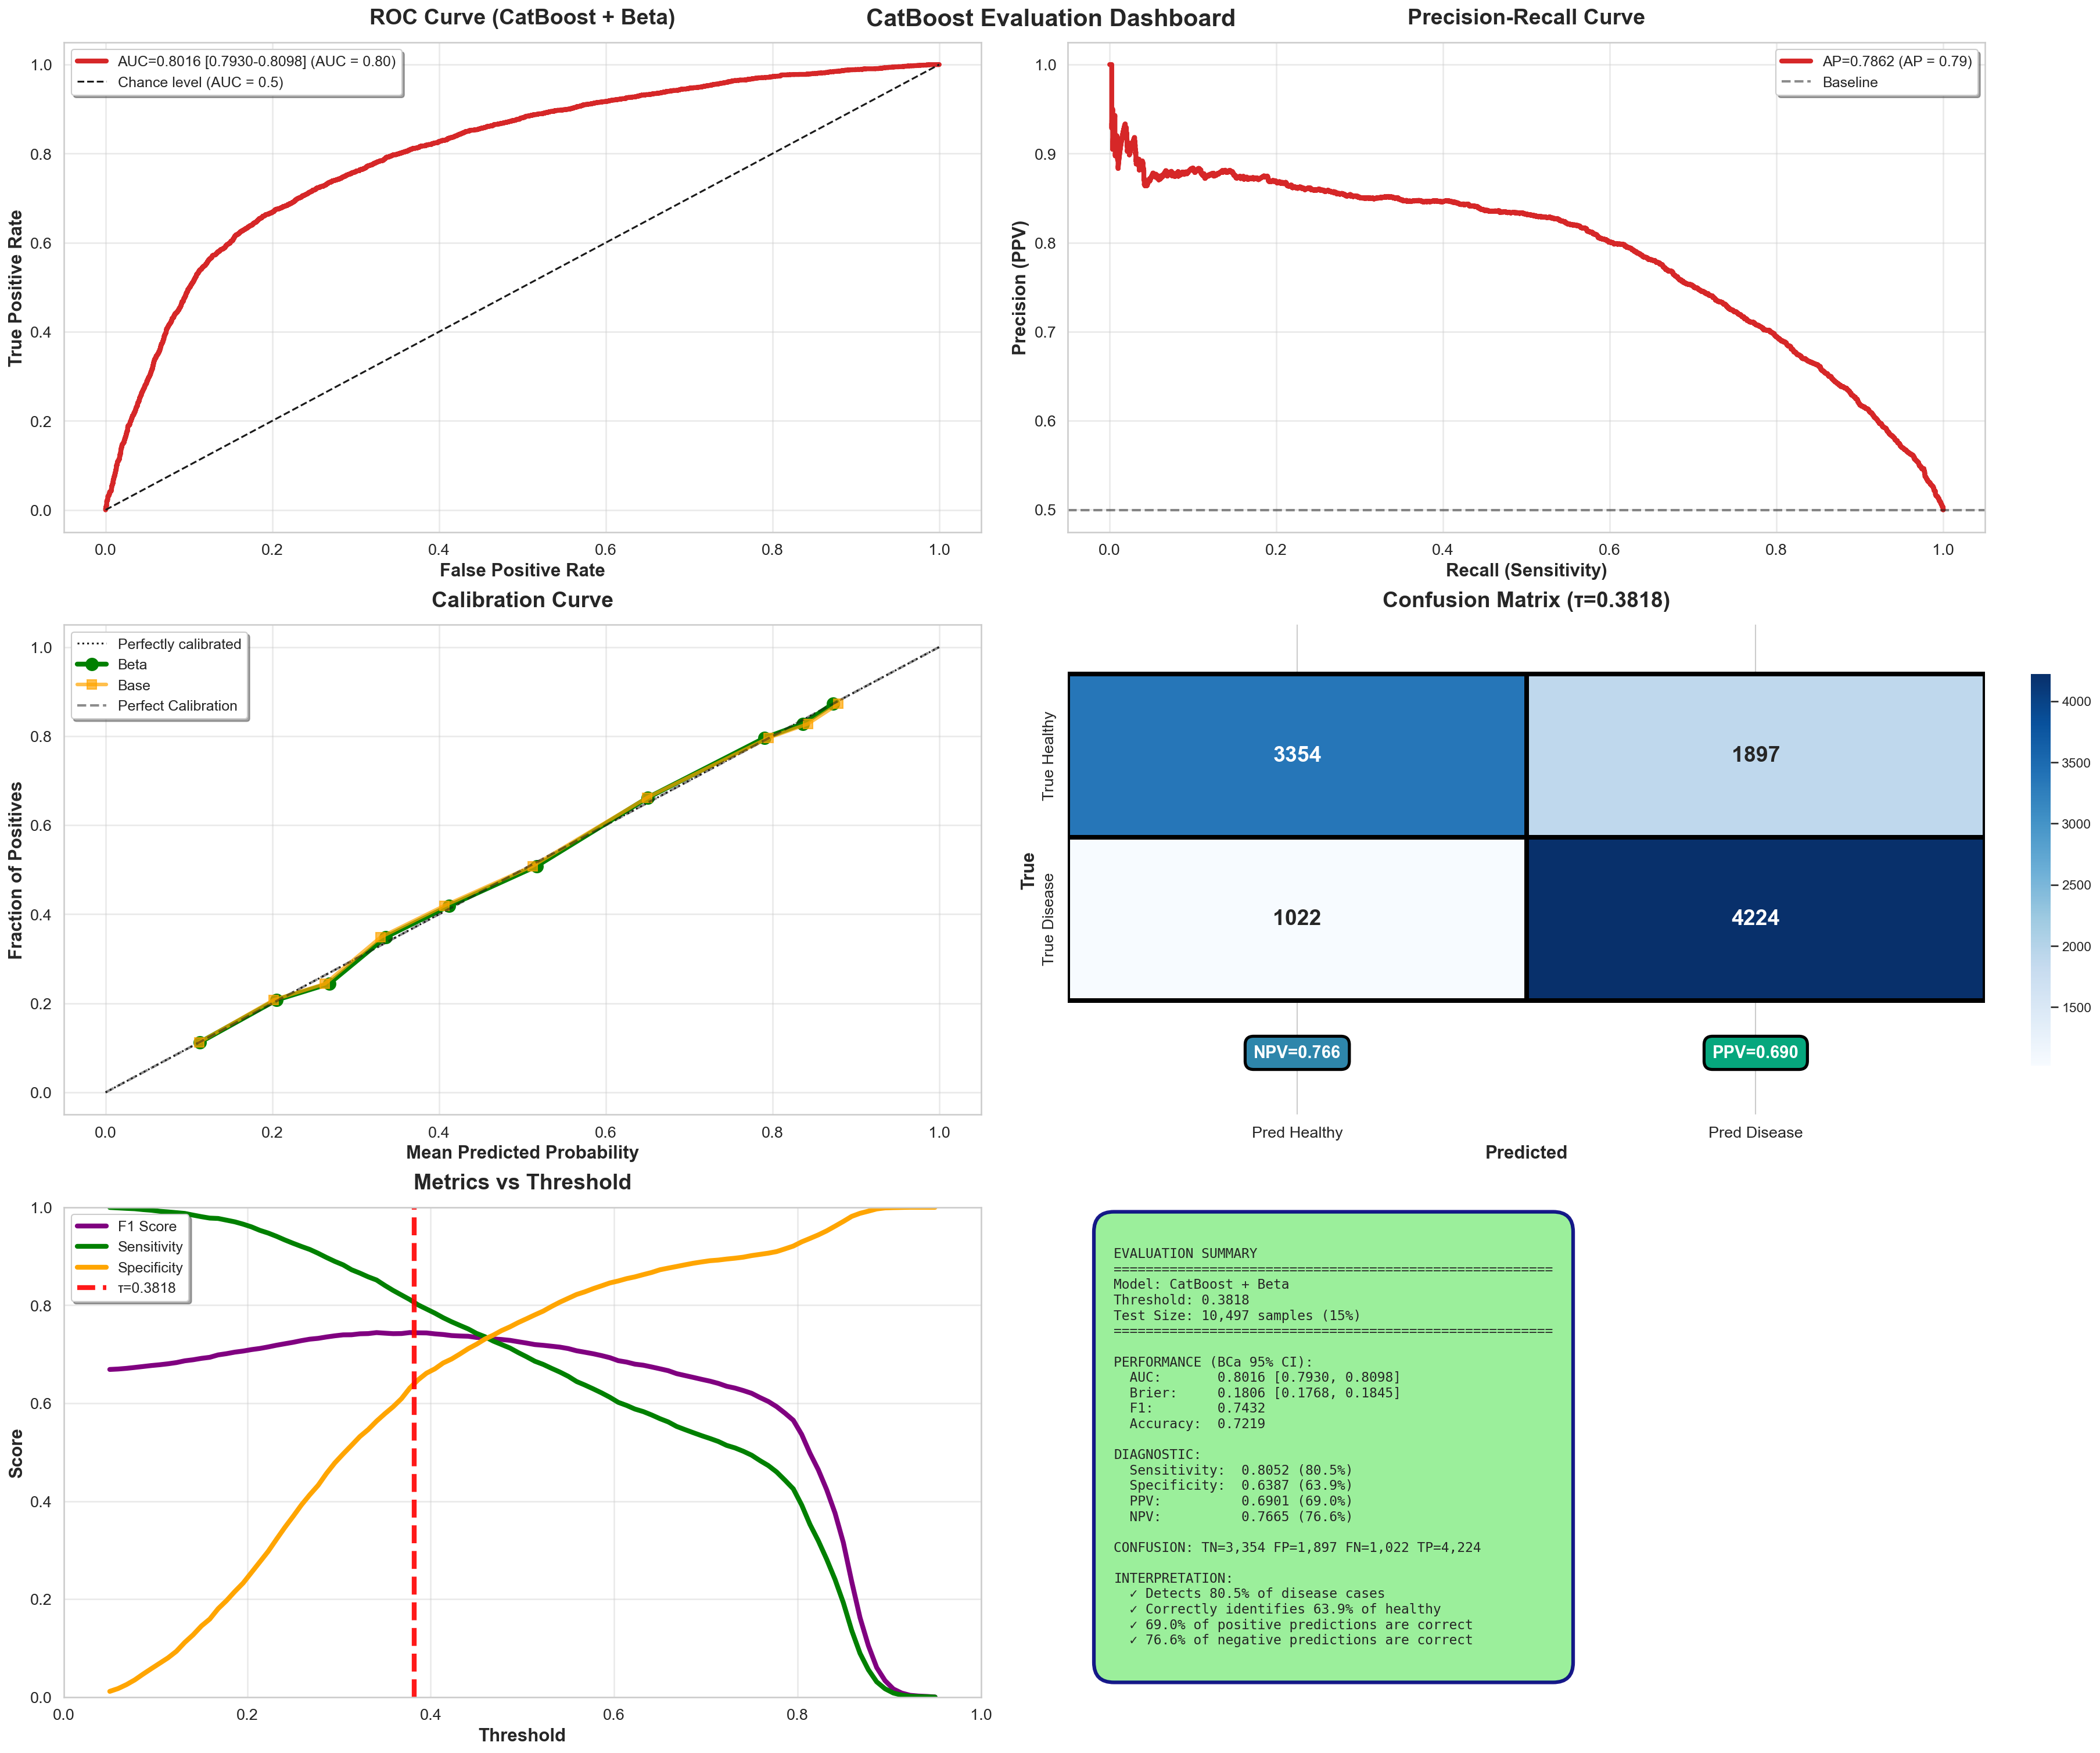

✅ Saved: evaluation_metrics.json

EVALUATION COMPLETE
AUC: 0.8016 | Sens: 0.805 | Spec: 0.639



In [2]:
"""
MODEL EVALUATION - HIGH CLARITY VERSION
Enhanced for publication-quality visualizations
"""

import numpy as np
import pandas as pd
from pathlib import Path
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, f1_score, confusion_matrix, 
    brier_score_loss, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import CalibrationDisplay
from sklearn.utils import resample
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# HIGH-QUALITY VISUALIZATION SETTINGS
# ============================================================================
plt.rcParams['figure.dpi'] = 150  # Higher display resolution
plt.rcParams['savefig.dpi'] = 300  # Publication quality
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Helvetica']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['grid.linewidth'] = 1.2
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['patch.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.constrained_layout.use'] = True

sns.set_theme(style="whitegrid")
sns.set_palette("husl")

try:
    from betacal import BetaCalibration
    BETACAL_AVAILABLE = True
except ImportError:
    BETACAL_AVAILABLE = False

N_BOOTSTRAPS = 1000
CONFIDENCE_LEVEL = 0.95
RANDOM_STATE = 42

# ============================================================================
# BOOTSTRAP CONFIDENCE INTERVALS
# ============================================================================
def calculate_bca_ci(bootstrap_estimates, observed_statistic, confidence_level=0.95):
    """Calculate BCa confidence intervals."""
    alpha = 1 - confidence_level
    prop_less = np.clip(np.mean(bootstrap_estimates < observed_statistic), 0.001, 0.999)
    z0 = np.clip(stats.norm.ppf(prop_less), -3, 3)
    
    jack_mean = np.mean(bootstrap_estimates)
    diff = jack_mean - bootstrap_estimates
    numerator = np.sum(diff ** 3)
    denominator = 6 * (np.sum(diff ** 2) ** 1.5)
    a = np.clip(numerator / denominator if denominator != 0 else 0, -1, 1)
    
    z_alpha_lower = stats.norm.ppf(alpha / 2)
    z_alpha_upper = stats.norm.ppf(1 - alpha / 2)
    
    try:
        p_lower = stats.norm.cdf(z0 + (z0 + z_alpha_lower) / (1 - a * (z0 + z_alpha_lower)))
        p_upper = stats.norm.cdf(z0 + (z0 + z_alpha_upper) / (1 - a * (z0 + z_alpha_upper)))
    except:
        p_lower = alpha / 2
        p_upper = 1 - alpha / 2
    
    p_lower = np.clip(p_lower * 100, 0.1, 99.9)
    p_upper = np.clip(p_upper * 100, 0.1, 99.9)
    
    return (float(np.percentile(bootstrap_estimates, p_lower)),
            float(np.percentile(bootstrap_estimates, p_upper)))

def bootstrap_metrics(y_true, y_proba, n_bootstraps=1000):
    """Bootstrap AUC and Brier with BCa CIs."""
    y_true_array = np.array(y_true)
    y_proba_array = np.array(y_proba)
    
    observed_auc = roc_auc_score(y_true_array, y_proba_array)
    observed_brier = brier_score_loss(y_true_array, y_proba_array)
    
    auc_scores, brier_scores = [], []
    pos_indices = np.where(y_true_array == 1)[0]
    neg_indices = np.where(y_true_array == 0)[0]
    
    np.random.seed(RANDOM_STATE)
    for _ in range(n_bootstraps):
        if len(pos_indices) > 0 and len(neg_indices) > 0:
            boot_pos = resample(pos_indices, replace=True, n_samples=len(pos_indices))
            boot_neg = resample(neg_indices, replace=True, n_samples=len(neg_indices))
            indices = np.concatenate([boot_pos, boot_neg])
        else:
            indices = resample(range(len(y_proba_array)), replace=True, n_samples=len(y_proba_array))
        
        probs_boot = y_proba_array[indices]
        true_boot = y_true_array[indices]
        
        if len(np.unique(true_boot)) > 1:
            try:
                auc_scores.append(roc_auc_score(true_boot, probs_boot))
                brier_scores.append(brier_score_loss(true_boot, probs_boot))
            except:
                continue
    
    auc_scores = np.array(auc_scores)
    brier_scores = np.array(brier_scores)
    
    return {
        'auc_mean': float(observed_auc),
        'auc_ci': calculate_bca_ci(auc_scores, observed_auc, CONFIDENCE_LEVEL),
        'brier_mean': float(observed_brier),
        'brier_ci': calculate_bca_ci(brier_scores, observed_brier, CONFIDENCE_LEVEL)
    }

# ============================================================================
# PROJECT SETUP
# ============================================================================
def get_project_root() -> Path:
    current = Path.cwd().resolve()
    for _ in range(5):
        if (current / 'artifacts').exists():
            return current
        if current == current.parent:
            break
        current = current.parent
    raise RuntimeError("Could not find project root with 'artifacts' directory")

PROJECT_ROOT = get_project_root()
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
MODEL_DIR = ARTIFACTS_DIR / 'model'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
FIGURES_DIR = REPORTS_DIR / 'figures'
METRICS_DIR = REPORTS_DIR / 'metrics'

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# LOAD MODEL & DATA
# ============================================================================
print("\n" + "="*70)
print("MODEL EVALUATION - FINAL TEST SET (15%)")
print("="*70)

package = joblib.load(MODEL_DIR / 'model_package.pkl')
model = package['base_model']
calibrator = package.get('calibrator', None)
threshold = package['threshold']
model_type = package.get('model_type', 'Unknown')
calibration_method = package.get('calibration_method', 'None')
risk_stats = package.get('risk_statistics', {})

print(f"\n✓ Model: {model_type} + {calibration_method.title()}")
print(f"✓ Threshold: {threshold:.4f}")

X_train = pd.read_parquet(DATA_DIR / 'X_train.parquet')
y_train = pd.read_parquet(DATA_DIR / 'y_train.parquet').iloc[:, 0].values
X_test_full = pd.read_parquet(DATA_DIR / 'X_test.parquet')
y_test_full = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0].values

X_cal, X_test, y_cal, y_test = train_test_split(
    X_test_full, y_test_full, test_size=0.5, stratify=y_test_full, random_state=RANDOM_STATE
)

total = len(X_train) + len(X_cal) + len(X_test)
print(f"\n✓ Data Split: Train {len(X_train)/total*100:.0f}% | Cal {len(X_cal)/total*100:.0f}% | Test {len(X_test)/total*100:.0f}%")
print(f"✓ Test: {len(X_test):,} samples | Disease: {y_test.mean():.1%}")

# ============================================================================
# PREDICTIONS & METRICS
# ============================================================================
y_prob_base = model.predict_proba(X_test)[:, 1]

if calibrator:
    if calibration_method == 'beta' and BETACAL_AVAILABLE:
        y_prob_final = calibrator.predict(y_prob_base)
    elif calibration_method == 'isotonic':
        y_prob_final = calibrator.predict(y_prob_base)
    else:
        y_prob_final = y_prob_base
else:
    y_prob_final = y_prob_base

print(f"\n✓ Bootstrap evaluation (n={N_BOOTSTRAPS})...")
boot_results = bootstrap_metrics(y_test, y_prob_final, n_bootstraps=N_BOOTSTRAPS)

print(f"  AUC:   {boot_results['auc_mean']:.4f} [{boot_results['auc_ci'][0]:.4f}, {boot_results['auc_ci'][1]:.4f}]")
print(f"  Brier: {boot_results['brier_mean']:.4f} [{boot_results['brier_ci'][0]:.4f}, {boot_results['brier_ci'][1]:.4f}]")

y_pred = (y_prob_final >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
accuracy = (tp + tn) / len(y_test)
f1 = f1_score(y_test, y_pred)
avg_precision = average_precision_score(y_test, y_prob_final)

print(f"  Sens: {sensitivity:.3f} | Spec: {specificity:.3f} | PPV: {ppv:.3f} | NPV: {npv:.3f}")

# ============================================================================
# HIGH-QUALITY VISUALIZATION
# ============================================================================
print("\n✓ Generating high-resolution dashboard...")

fig, axes = plt.subplots(3, 2, figsize=(24, 20))  # Larger figure
axes = axes.ravel()

# 1. ROC Curve
RocCurveDisplay.from_predictions(
    y_test, y_prob_final, 
    name=f'AUC={boot_results["auc_mean"]:.4f} [{boot_results["auc_ci"][0]:.4f}-{boot_results["auc_ci"][1]:.4f}]', 
    ax=axes[0], color='#d62728', lw=4, plot_chance_level=True
)
axes[0].set_title(f'ROC Curve ({model_type} + {calibration_method.title()})', 
                  fontsize=18, fontweight='bold', pad=15)
axes[0].set_xlabel('False Positive Rate', fontsize=15, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=15, fontweight='bold')
axes[0].tick_params(labelsize=13)
axes[0].legend(fontsize=12, frameon=True, shadow=True)
axes[0].grid(alpha=0.4, linewidth=1.3)

# 2. Precision-Recall
PrecisionRecallDisplay.from_predictions(
    y_test, y_prob_final, name=f'AP={avg_precision:.4f}', 
    ax=axes[1], color='#d62728', lw=4
)
axes[1].axhline(y_test.mean(), color='k', linestyle='--', lw=2, alpha=0.5, label='Baseline')
axes[1].set_title('Precision-Recall Curve', fontsize=18, fontweight='bold', pad=15)
axes[1].set_xlabel('Recall (Sensitivity)', fontsize=15, fontweight='bold')
axes[1].set_ylabel('Precision (PPV)', fontsize=15, fontweight='bold')
axes[1].tick_params(labelsize=13)
axes[1].legend(fontsize=12, frameon=True, shadow=True)
axes[1].grid(alpha=0.4, linewidth=1.3)

# 3. Calibration
CalibrationDisplay.from_predictions(
    y_test, y_prob_final, n_bins=10, strategy='quantile', 
    ax=axes[2], name=calibration_method.title(), color='green', marker='o', linewidth=4, markersize=10
)
if calibrator:
    CalibrationDisplay.from_predictions(
        y_test, y_prob_base, n_bins=10, strategy='quantile', 
        ax=axes[2], name='Base', color='orange', marker='s', linewidth=3, markersize=8, alpha=0.7
    )
axes[2].plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Perfect Calibration')
axes[2].set_title('Calibration Curve', fontsize=18, fontweight='bold', pad=15)
axes[2].set_xlabel('Mean Predicted Probability', fontsize=15, fontweight='bold')
axes[2].set_ylabel('Fraction of Positives', fontsize=15, fontweight='bold')
axes[2].tick_params(labelsize=13)
axes[2].legend(fontsize=12, frameon=True, shadow=True)
axes[2].grid(alpha=0.4, linewidth=1.3)

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Pred Healthy', 'Pred Disease'],
            yticklabels=['True Healthy', 'True Disease'],
            annot_kws={"size": 18, "weight": "bold"},
            ax=axes[3], linewidths=3, linecolor='black', cbar_kws={'shrink': 0.8})
axes[3].set_title(f'Confusion Matrix (τ={threshold:.4f})', fontsize=18, fontweight='bold', pad=15)
axes[3].set_xlabel('Predicted', fontsize=15, fontweight='bold')
axes[3].set_ylabel('True', fontsize=15, fontweight='bold')
axes[3].tick_params(labelsize=13)

# Add NPV/PPV badges
axes[3].text(0.5, 2.35, f'NPV={npv:.3f}', fontsize=14, fontweight='bold', 
            ha='center', color='white',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#2E86AB', edgecolor='black', linewidth=2.5))
axes[3].text(1.5, 2.35, f'PPV={ppv:.3f}', fontsize=14, fontweight='bold', 
            ha='center', color='white',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#06A77D', edgecolor='black', linewidth=2.5))
axes[3].set_ylim(2.7, -0.3)

# 5. Threshold Analysis
thresholds = np.linspace(0.05, 0.95, 100)
f1_scores = [f1_score(y_test, (y_prob_final >= t).astype(int)) for t in thresholds]
sens_scores = [confusion_matrix(y_test, (y_prob_final >= t).astype(int)).ravel()[3] / 
               (confusion_matrix(y_test, (y_prob_final >= t).astype(int)).ravel()[3] + 
                confusion_matrix(y_test, (y_prob_final >= t).astype(int)).ravel()[2]) for t in thresholds]
spec_scores = [confusion_matrix(y_test, (y_prob_final >= t).astype(int)).ravel()[0] / 
               (confusion_matrix(y_test, (y_prob_final >= t).astype(int)).ravel()[0] + 
                confusion_matrix(y_test, (y_prob_final >= t).astype(int)).ravel()[1]) for t in thresholds]

axes[4].plot(thresholds, f1_scores, lw=4, label='F1 Score', color='purple')
axes[4].plot(thresholds, sens_scores, lw=4, label='Sensitivity', color='green')
axes[4].plot(thresholds, spec_scores, lw=4, label='Specificity', color='orange')
axes[4].axvline(threshold, color='red', linestyle='--', lw=4, alpha=0.9, label=f'τ={threshold:.4f}')
axes[4].set_title('Metrics vs Threshold', fontsize=18, fontweight='bold', pad=15)
axes[4].set_xlabel('Threshold', fontsize=15, fontweight='bold')
axes[4].set_ylabel('Score', fontsize=15, fontweight='bold')
axes[4].set_xlim([0, 1])
axes[4].set_ylim([0, 1])
axes[4].tick_params(labelsize=13)
axes[4].legend(fontsize=12, frameon=True, shadow=True)
axes[4].grid(alpha=0.4, linewidth=1.3)

# 6. Summary
axes[5].axis('off')
summary = f"""
EVALUATION SUMMARY
{'='*55}
Model: {model_type} + {calibration_method.title()}
Threshold: {threshold:.4f}
Test Size: {len(X_test):,} samples ({len(X_test)/total*100:.0f}%)
{'='*55}

PERFORMANCE (BCa 95% CI):
  AUC:       {boot_results['auc_mean']:.4f} [{boot_results['auc_ci'][0]:.4f}, {boot_results['auc_ci'][1]:.4f}]
  Brier:     {boot_results['brier_mean']:.4f} [{boot_results['brier_ci'][0]:.4f}, {boot_results['brier_ci'][1]:.4f}]
  F1:        {f1:.4f}
  Accuracy:  {accuracy:.4f}

DIAGNOSTIC:
  Sensitivity:  {sensitivity:.4f} ({sensitivity*100:.1f}%)
  Specificity:  {specificity:.4f} ({specificity*100:.1f}%)
  PPV:          {ppv:.4f} ({ppv*100:.1f}%)
  NPV:          {npv:.4f} ({npv*100:.1f}%)

CONFUSION: TN={tn:,} FP={fp:,} FN={fn:,} TP={tp:,}

INTERPRETATION:
  ✓ Detects {sensitivity*100:.1f}% of disease cases
  ✓ Correctly identifies {specificity*100:.1f}% of healthy
  ✓ {ppv*100:.1f}% of positive predictions are correct
  ✓ {npv*100:.1f}% of negative predictions are correct
"""

axes[5].text(0.05, 0.95, summary, transform=axes[5].transAxes,
            fontsize=11, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round,pad=1.5', facecolor='lightgreen', 
                     alpha=0.9, edgecolor='navy', linewidth=3, pad=2))

plt.suptitle(f'{model_type} Evaluation Dashboard', 
             fontsize=20, fontweight='bold', y=0.998)

# Save with maximum quality
plt.savefig(FIGURES_DIR / '01_model_evaluation_dashboard.png', 
            dpi=300, bbox_inches='tight', facecolor='white', 
            edgecolor='none', format='png', metadata={'Software': 'Matplotlib'})
print(f"\n✅ Saved: 01_model_evaluation_dashboard.png (300 DPI)")
plt.show()
plt.close()

# ============================================================================
# SAVE METRICS
# ============================================================================
metrics = {
    'model_info': {'type': model_type, 'calibration': calibration_method, 'threshold': float(threshold)},
    'data_split': {'train_n': int(len(X_train)), 'cal_n': int(len(X_cal)), 'test_n': int(len(X_test))},
    'test_performance': {
        'auc': float(boot_results['auc_mean']), 'auc_ci': boot_results['auc_ci'],
        'brier': float(boot_results['brier_mean']), 'brier_ci': boot_results['brier_ci'],
        'f1': float(f1), 'accuracy': float(accuracy)
    },
    'diagnostic': {
        'sensitivity': float(sensitivity), 'specificity': float(specificity),
        'ppv': float(ppv), 'npv': float(npv)
    },
    'confusion_matrix': {'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)}
}

with open(METRICS_DIR / 'evaluation_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Saved: evaluation_metrics.json")
print("\n" + "="*70)
print("EVALUATION COMPLETE")
print(f"AUC: {boot_results['auc_mean']:.4f} | Sens: {sensitivity:.3f} | Spec: {specificity:.3f}")
print("="*70 + "\n")


### risk score analysis


RISK GROUP ANALYSIS (3-Group CART System)

Loading model package...
✓ Model: CatBoost
✓ Calibration: beta
✓ Threshold: 0.3818
✓ Risk Groups: ['Low', 'Moderate', 'High']

Loading and splitting test data (15%)...
✓ Test set: 10,497 samples (15% of total)
✓ Disease prevalence: 50.0%

Generating predictions...

Applying CART risk stratification...
✓ Applied CART stratification using saved mapping
  Unique leaves: [2 3 4]
  Risk groups: ['High' 'Low' 'Moderate']
✓ Saved: df_risk_profiles.parquet

Analyzing risk groups...
  Low: 3,212 patients (19.0% disease, NPV=0.000)
  Moderate: 2,839 patients (41.6% disease, NPV=0.645)
  High: 4,446 patients (77.8% disease, NPV=0.000)

Generating visualizations...
✅ Saved: 02_risk_analysis.png


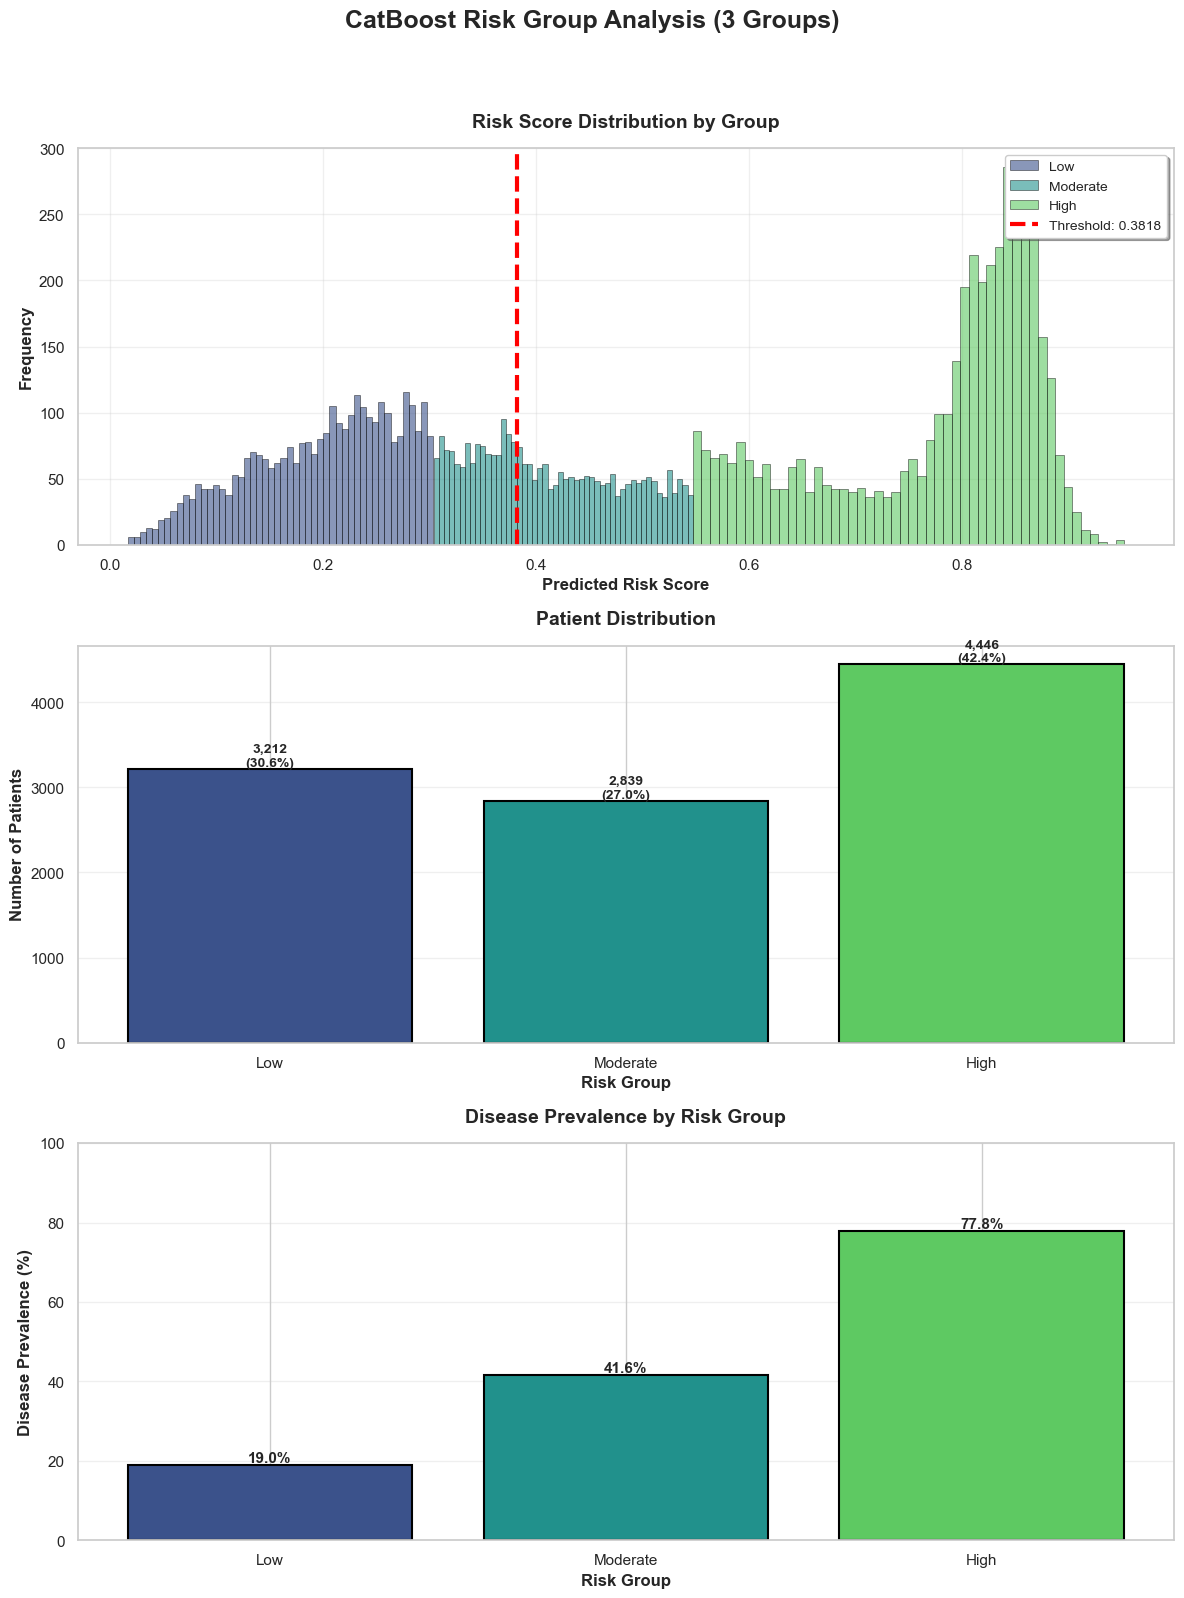


Saving metrics...
✅ Saved: risk_group_metrics.json

RISK GROUP ANALYSIS COMPLETE

RISK GROUP PERFORMANCE:
Risk_Group  N_Patients  Disease_Prevalence      NPV     PPV
       Low        3212           18.960149 0.000000 0.00000
  Moderate        2839           41.563931 0.645189 0.45791
      High        4446           77.755286 0.000000 0.00000



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
sns.set_palette("husl")

print("\n" + "="*80)
print("RISK GROUP ANALYSIS (3-Group CART System)")
print("="*80)

RANDOM_STATE = 42

def get_project_root() -> Path:
    current = Path.cwd().resolve()
    max_depth = 5
    depth = 0
    
    while depth < max_depth and current != current.parent:
        if (current / 'artifacts').exists():
            return current
        current = current.parent
        depth += 1
    
    raise RuntimeError("Could not find project root")

PROJECT_ROOT = get_project_root()
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
MODEL_DIR = ARTIFACTS_DIR / 'model'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
FIGURES_DIR = REPORTS_DIR / 'figures'
METRICS_DIR = REPORTS_DIR / 'metrics'

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

print("\nLoading model package...")
package = joblib.load(MODEL_DIR / 'model_package.pkl')

model = package['base_model']
calibrator = package.get('calibrator', None)
cart_model = package.get('cart_model')
threshold = package['threshold']
leaf_to_risk = package.get('leaf_to_risk', {})  # ✅ Use saved mapping
risk_stats_from_package = package.get('risk_statistics', {})
model_type = package.get('model_type', 'Unknown')
calibration_method = package.get('calibration_method', 'None')

if not cart_model or not leaf_to_risk:
    print("❌ CART model or leaf_to_risk mapping not found!")
    exit(1)

print(f"✓ Model: {model_type}")
print(f"✓ Calibration: {calibration_method}")
print(f"✓ Threshold: {threshold:.4f}")
print(f"✓ Risk Groups: {list(risk_stats_from_package.keys())}")

print("\nLoading and splitting test data (15%)...")
# Load FULL test data (30% of total)
X_test_full = pd.read_parquet(DATA_DIR / 'X_test.parquet')
y_test_full = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0].values

# ✅ Split 50/50 → 15% cal, 15% test (matches training)
X_cal, X_test, y_cal, y_test = train_test_split(
    X_test_full, y_test_full, test_size=0.5, 
    stratify=y_test_full, random_state=RANDOM_STATE
)

print(f"✓ Test set: {X_test.shape[0]:,} samples (15% of total)")
print(f"✓ Disease prevalence: {y_test.mean():.1%}")

print("\nGenerating predictions...")
y_prob = model.predict_proba(X_test)[:, 1]
if calibrator:
    if calibration_method == 'beta':
        y_prob = calibrator.predict(y_prob)
    elif calibration_method == 'isotonic':
        y_prob = calibrator.predict(y_prob)

y_pred = (y_prob >= threshold).astype(int)

print("\nApplying CART risk stratification...")
X_cart = pd.DataFrame({'Predicted_Risk': y_prob})
leaves = cart_model.apply(X_cart)

# ✅ Use the saved leaf_to_risk mapping from training
risk_labels = np.array([leaf_to_risk.get(leaf, 'Unknown') for leaf in leaves])

print(f"✓ Applied CART stratification using saved mapping")
print(f"  Unique leaves: {np.unique(leaves)}")
print(f"  Risk groups: {np.unique(risk_labels)}")

# Create risk profiles
df_risk_profiles = pd.DataFrame({
    'Patient_Index': np.arange(len(y_test)),
    'Risk_Score': y_prob,
    'Risk_Level': risk_labels,
    'Threshold': threshold,
    'Predicted_Disease': y_pred,
    'Actual_Disease': y_test,
    'Correct': (y_pred == y_test).astype(int)
})

df_risk_profiles.to_parquet(METRICS_DIR / 'df_risk_profiles.parquet', index=False)
print(f"✓ Saved: df_risk_profiles.parquet")

print("\nAnalyzing risk groups...")
risk_order = ['Low', 'Moderate', 'High']
group_stats = []

for risk in risk_order:
    mask = risk_labels == risk
    
    if mask.sum() == 0:
        print(f"  ⚠️  No patients in {risk} group")
        continue
    
    y_group = y_test[mask]
    proba_group = y_prob[mask]
    pred_group = y_pred[mask]
    
    # Handle edge cases
    if len(np.unique(y_group)) == 1 or len(np.unique(pred_group)) == 1:
        # Only one class present
        prevalence = y_group.mean()
        n = mask.sum()
        
        if y_group[0] == 0 and pred_group[0] == 0:
            tn, fp, fn, tp = n, 0, 0, 0
        elif y_group[0] == 1 and pred_group[0] == 1:
            tn, fp, fn, tp = 0, 0, 0, n
        elif y_group[0] == 0 and pred_group[0] == 1:
            tn, fp, fn, tp = 0, n, 0, 0
        else:
            tn, fp, fn, tp = 0, 0, n, 0
    else:
        cm = confusion_matrix(y_group, pred_group)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        elif cm.shape == (1, 1):
            if y_group[0] == 0:
                tn, fp, fn, tp = cm[0, 0], 0, 0, 0
            else:
                tn, fp, fn, tp = 0, 0, 0, cm[0, 0]
        else:
            tn, fp, fn, tp = 0, 0, 0, 0
        
        prevalence = y_group.mean()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    group_stats.append({
        'Risk_Group': risk,
        'N_Patients': int(mask.sum()),
        'Percentage': float(mask.sum() / len(y_test) * 100),
        'Disease_Prevalence': float(prevalence * 100),
        'Mean_Risk_Score': float(proba_group.mean()),
        'Sensitivity': float(sensitivity),
        'Specificity': float(specificity),
        'PPV': float(ppv),
        'NPV': float(npv),
        'TP': int(tp), 'FP': int(fp), 'TN': int(tn), 'FN': int(fn)
    })
    
    print(f"  {risk}: {mask.sum():,} patients ({prevalence*100:.1f}% disease, NPV={npv:.3f})")

stats_df = pd.DataFrame(group_stats)

print("\nGenerating visualizations...")
colors = sns.color_palette("viridis", n_colors=len(risk_order))
color_map = dict(zip(risk_order, colors))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 16))

# Risk Score Distribution
for risk in risk_order:
    mask = risk_labels == risk
    if mask.sum() > 0:
        ax1.hist(y_prob[mask], bins=50, alpha=0.6, label=risk,
                color=color_map[risk], edgecolor='black', linewidth=0.5)

ax1.axvline(threshold, color='red', linestyle='--', linewidth=3,
           label=f'Threshold: {threshold:.4f}')
ax1.set_xlabel('Predicted Risk Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Risk Score Distribution by Group', fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='upper right', frameon=True, shadow=True, fontsize=10)
ax1.grid(True, alpha=0.3)

# Patient Distribution
bars = ax2.bar(
    stats_df['Risk_Group'], 
    stats_df['N_Patients'],
    color=[color_map[r] for r in stats_df['Risk_Group']],
    edgecolor='black', 
    linewidth=1.5
)
ax2.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax2.set_xlabel('Risk Group', fontsize=12, fontweight='bold')
ax2.set_title('Patient Distribution', fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({height/stats_df["N_Patients"].sum()*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Disease Prevalence
bars3 = ax3.bar(
    stats_df['Risk_Group'], 
    stats_df['Disease_Prevalence'],
    color=[color_map[r] for r in stats_df['Risk_Group']],
    edgecolor='black', 
    linewidth=1.5
)
ax3.set_ylabel('Disease Prevalence (%)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Risk Group', fontsize=12, fontweight='bold')
ax3.set_title('Disease Prevalence by Risk Group', fontsize=14, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0, 100])

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.suptitle(f'{model_type} Risk Group Analysis (3 Groups)', fontsize=18, fontweight='bold', y=0.998)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(FIGURES_DIR / '02_risk_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Saved: 02_risk_analysis.png")
plt.show()
plt.close()

print("\nSaving metrics...")
stats_df.to_csv(METRICS_DIR / 'risk_group_metrics.csv', index=False)

metrics_json = {
    'model_info': {
        'type': model_type, 
        'calibration': calibration_method, 
        'threshold': float(threshold)
    },
    'data_split': {
        'test_samples': int(len(y_test)),
        'test_percentage': 15.0  # 15% of total data
    },
    'risk_groups': {}
}

for _, row in stats_df.iterrows():
    metrics_json['risk_groups'][row['Risk_Group']] = {
        'n_patients': int(row['N_Patients']),
        'percentage': float(row['Percentage']),
        'disease_prevalence': float(row['Disease_Prevalence']),
        'mean_risk_score': float(row['Mean_Risk_Score']),
        'sensitivity': float(row['Sensitivity']),
        'specificity': float(row['Specificity']),
        'ppv': float(row['PPV']),
        'npv': float(row['NPV'])
    }

with open(METRICS_DIR / 'risk_group_metrics.json', 'w') as f:
    json.dump(metrics_json, f, indent=2)

print(f"✅ Saved: risk_group_metrics.json")

print("\n" + "="*80)
print("RISK GROUP ANALYSIS COMPLETE")
print("="*80)
print("\nRISK GROUP PERFORMANCE:")
print(stats_df[['Risk_Group', 'N_Patients', 'Disease_Prevalence', 'NPV', 'PPV']].to_string(index=False))
print("="*80 + "\n")

### Shap barplot


SHAP FEATURE IMPORTANCE ANALYSIS

Loading model package...
✓ Model: CatBoost + beta Calibration
✓ Threshold: 0.3818

Loading test data (15%)...
✓ Test set: (10497, 14) (15% of total)
✓ Disease prevalence: 50.0%
✓ Features: 14

Evaluating model on test set...
  Base Brier:       0.1806
  Calibrated Brier: 0.1806
  AUC:              0.8016

Subsampling for SHAP (target: 6000)...
✓ SHAP sample: (6000, 14)

Computing SHAP values...
  (This may take a few minutes...)
✓ SHAP values shape: (6000, 14)

Computing feature impacts...
✓ Feature importance calculated

Saving SHAP results...
✓ Saved: shap_feature_importance.csv
✓ Saved: shap_top10_summary.txt

Creating visualization...
✅ Saved: 03_shap_feature_importance.png


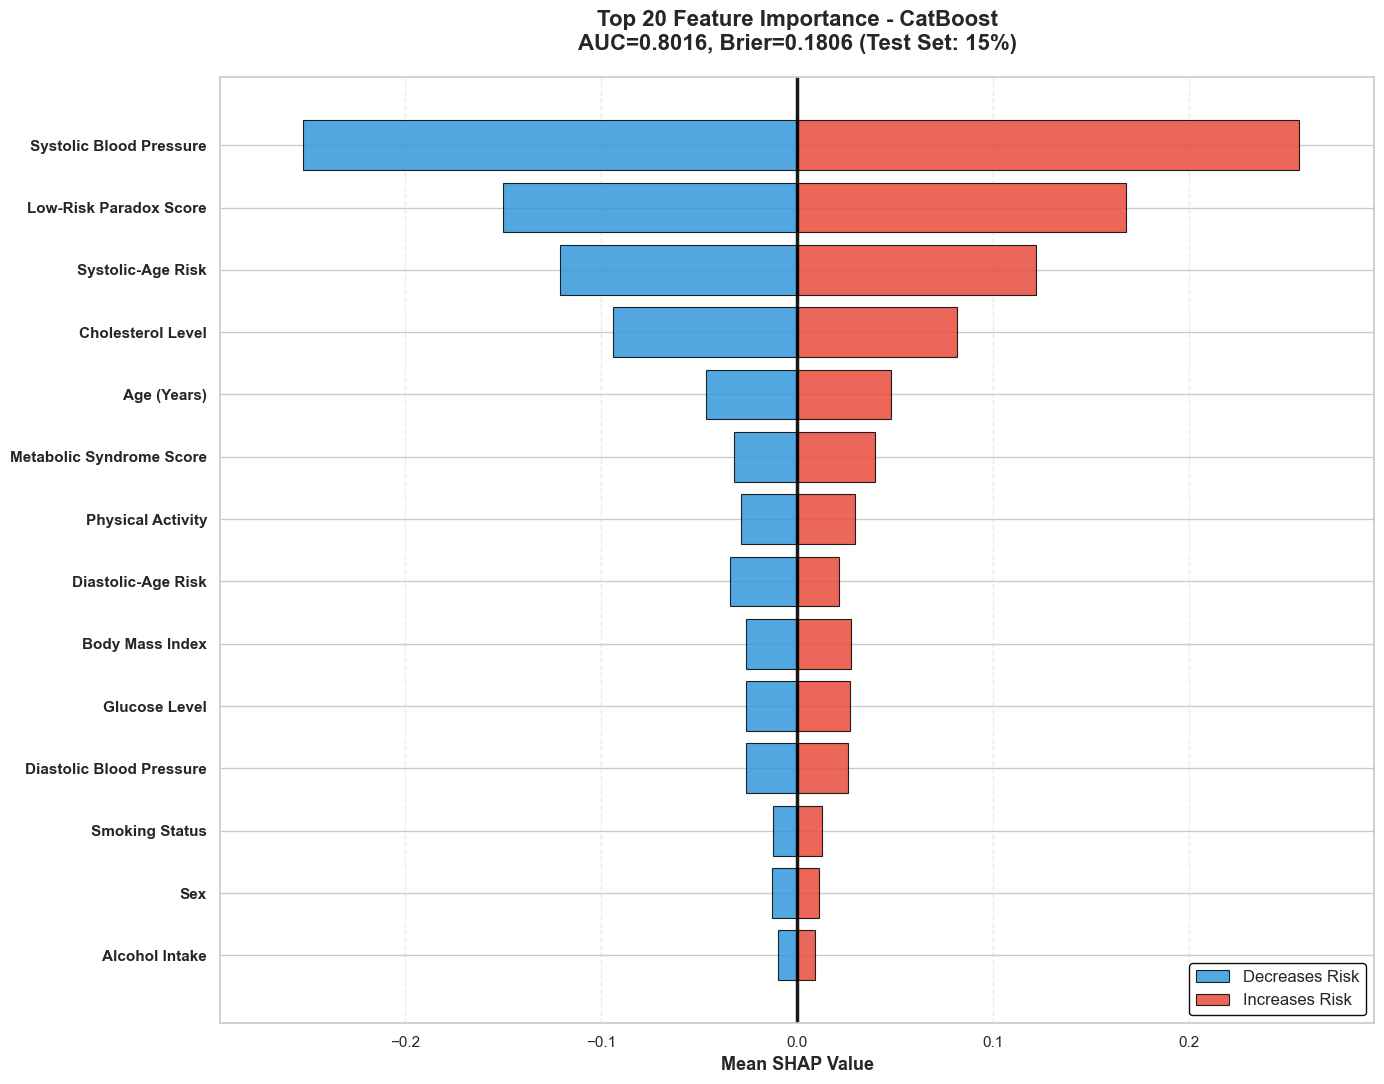


SHAP FEATURE IMPORTANCE SUMMARY
Model:        CatBoost + beta
Data Split:   70% train | 15% cal | 15% test
Test AUC:     0.8016
Test Brier:   0.1806
Sample Size:  6,000

Top 10 Most Important Features:
                 feature  importance  positive_impact  negative_impact
 Systolic Blood Pressure    0.508195         0.256073        -0.252122
  Low-Risk Paradox Score    0.318261         0.168010        -0.150251
       Systolic-Age Risk    0.243346         0.122124        -0.121221
       Cholesterol Level    0.175432         0.081444        -0.093988
             Age (Years)    0.094525         0.047802        -0.046722
Metabolic Syndrome Score    0.071727         0.039584        -0.032142
       Physical Activity    0.058180         0.029702        -0.028478
      Diastolic-Age Risk    0.055497         0.021349        -0.034149
         Body Mass Index    0.053389         0.027404        -0.025985
           Glucose Level    0.052757         0.026904        -0.025854

✅ SHAP analysis

In [8]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except ImportError:
    plt.style.use('seaborn-v0_8-whitegrid')

print("\n" + "="*80)
print("SHAP FEATURE IMPORTANCE ANALYSIS")
print("="*80)

SAMPLE_SIZE = 6000
RANDOM_STATE = 42

FEATURE_NAME_MAPPING = {
    'Sex': 'Sex',
    'Smoking_Status': 'Smoking Status',
    'Alcohol_Intake': 'Alcohol Intake',
    'Physical_Activity': 'Physical Activity',
    'Cholesterol_Level': 'Cholesterol Level',
    'Glucose_Level': 'Glucose Level',
    'Systolic_BP': 'Systolic Blood Pressure',
    'Diastolic_BP': 'Diastolic Blood Pressure',
    'Age_Years': 'Age (Years)',
    'BMI': 'Body Mass Index',
    'Systolic_Age_risk': 'Systolic-Age Risk',
    'Diastolic_Age_risk': 'Diastolic-Age Risk',
    'Metabolic_Syndrome_Score': 'Metabolic Syndrome Score',
    'Low_Risk_Paradox_Score': 'Low-Risk Paradox Score',
}

def get_project_root() -> Path:
    current = Path.cwd().resolve()
    max_depth = 5
    depth = 0
    
    while depth < max_depth and current != current.parent:
        if (current / 'artifacts').exists():
            return current
        current = current.parent
        depth += 1
    
    raise RuntimeError("Could not find project root")

if __name__ == "__main__":
    PROJECT_ROOT = get_project_root()
    ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
    DATA_DIR = ARTIFACTS_DIR / 'split data sets'
    MODEL_DIR = ARTIFACTS_DIR / 'model'
    REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
    FIGURES_DIR = REPORTS_DIR / 'figures'
    METRICS_DIR = REPORTS_DIR / 'metrics'
    
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)
    METRICS_DIR.mkdir(parents=True, exist_ok=True)
    
    print("\nLoading model package...")
    package = joblib.load(MODEL_DIR / 'model_package.pkl')
    
    model = package['base_model']
    calibrator = package.get('calibrator', None)
    threshold = package['threshold']
    performance = package.get('test_performance', {})
    model_type = package.get('model_type', 'Unknown')
    calibration_method = package.get('calibration_method', 'None')
    
    print(f"✓ Model: {model_type} + {calibration_method} Calibration")
    print(f"✓ Threshold: {threshold:.4f}")
    
    print("\nLoading test data (15%)...")
    # Load full test set (30% of total)
    X_test_full = pd.read_parquet(DATA_DIR / 'X_test.parquet')
    y_test_full = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0].values
    
    # ✅ Split into cal + test (same as training: 15% each)
    X_cal, X_test, y_cal, y_test = train_test_split(
        X_test_full, y_test_full, test_size=0.5, 
        stratify=y_test_full, random_state=RANDOM_STATE
    )
    
    print(f"✓ Test set: {X_test.shape} (15% of total)")
    print(f"✓ Disease prevalence: {y_test.mean():.1%}")
    
    features = X_test.columns.tolist()
    print(f"✓ Features: {len(features)}")
    
    print("\nEvaluating model on test set...")
    y_prob_base = model.predict_proba(X_test)[:, 1]
    
    # ✅ Handle calibration properly
    if calibrator:
        if calibration_method == 'beta':
            try:
                from betacal import BetaCalibration
                y_prob_cal = calibrator.predict(y_prob_base)
            except:
                y_prob_cal = y_prob_base
        elif calibration_method == 'isotonic':
            y_prob_cal = calibrator.predict(y_prob_base)
        else:
            y_prob_cal = y_prob_base
    else:
        y_prob_cal = y_prob_base
    
    brier_base = brier_score_loss(y_test, y_prob_base)
    brier_cal = brier_score_loss(y_test, y_prob_cal)
    auc = roc_auc_score(y_test, y_prob_cal)
    
    print(f"  Base Brier:       {brier_base:.4f}")
    print(f"  Calibrated Brier: {brier_cal:.4f}")
    print(f"  AUC:              {auc:.4f}")
    
    print(f"\nSubsampling for SHAP (target: {SAMPLE_SIZE})...")
    if len(X_test) > SAMPLE_SIZE:
        sample_indices = np.random.RandomState(RANDOM_STATE).choice(
            len(X_test), size=SAMPLE_SIZE, replace=False
        )
        X_sample = X_test.iloc[sample_indices]
    else:
        X_sample = X_test.copy()
    
    X_sample = X_sample.astype('float32')
    print(f"✓ SHAP sample: {X_sample.shape}")
    
    print("\nComputing SHAP values...")
    print("  (This may take a few minutes...)")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    
    # Handle different SHAP output formats
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # For binary classification
    elif len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]  # For multi-output
    
    print(f"✓ SHAP values shape: {shap_values.shape}")
    
    print("\nComputing feature impacts...")
    shap_importance = np.abs(shap_values).mean(axis=0)
    shap_positive = np.where(shap_values > 0, shap_values, 0).mean(axis=0)
    shap_negative = np.where(shap_values < 0, shap_values, 0).mean(axis=0)
    
    shap_summary = pd.DataFrame({
        'feature_code': features,
        'feature': [FEATURE_NAME_MAPPING.get(f, f) for f in features],
        'importance': shap_importance,
        'positive_impact': shap_positive,
        'negative_impact': shap_negative
    })
    
    top_features = shap_summary.nlargest(20, 'importance').sort_values('importance', ascending=True)
    print("✓ Feature importance calculated")
    
    print("\nSaving SHAP results...")
    shap_summary.sort_values('importance', ascending=False).to_csv(
        METRICS_DIR / 'shap_feature_importance.csv', index=False
    )
    print(f"✓ Saved: shap_feature_importance.csv")
    
    top10 = shap_summary.nlargest(10, 'importance')[['feature', 'importance', 'positive_impact', 'negative_impact']]
    with open(METRICS_DIR / 'shap_top10_summary.txt', 'w') as f:
        f.write("="*80 + "\n")
        f.write(f"SHAP TOP 10 FEATURES - {model_type.upper()}\n")
        f.write("="*80 + "\n")
        f.write(f"Model: {model_type} + {calibration_method} Calibration\n")
        f.write(f"Test AUC: {auc:.4f}\n")
        f.write(f"Test Brier: {brier_cal:.4f}\n")
        f.write(f"Sample Size: {X_sample.shape[0]}\n")
        f.write(f"Data Split: 70% train | 15% cal | 15% test\n")
        f.write("="*80 + "\n\n")
        f.write(top10.to_string(index=False))
        f.write("\n" + "="*80 + "\n")
    print(f"✓ Saved: shap_top10_summary.txt")
    
    print("\nCreating visualization...")
    fig, ax = plt.subplots(figsize=(14, 11))
    y_positions = np.arange(len(top_features))
    
    ax.barh(y_positions, top_features['negative_impact'],
            color='#3498db', alpha=0.85, label='Decreases Risk',
            edgecolor='black', linewidth=0.8)
    ax.barh(y_positions, top_features['positive_impact'],
            color='#e74c3c', alpha=0.85, label='Increases Risk',
            edgecolor='black', linewidth=0.8)
    
    ax.set_yticks(y_positions)
    ax.set_yticklabels(top_features['feature'], fontsize=11, fontweight='bold')
    ax.set_xlabel('Mean SHAP Value', fontsize=13, fontweight='bold')
    
    title = f'Top 20 Feature Importance - {model_type}\n'
    title += f'AUC={auc:.4f}, Brier={brier_cal:.4f} (Test Set: 15%)'
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    ax.axvline(x=0, color='black', linewidth=2.5, alpha=0.9, linestyle='-')
    ax.grid(axis='x', alpha=0.4, linestyle='--')
    ax.set_axisbelow(True)
    ax.legend(loc='lower right', fontsize=12, framealpha=0.95, edgecolor='black')
    
    max_abs_val = max(
        abs(top_features['negative_impact'].min()),
        abs(top_features['positive_impact'].max())
    )
    ax.set_xlim([-max_abs_val * 1.15, max_abs_val * 1.15])
    
    plt.tight_layout()
    output_path = FIGURES_DIR / '03_shap_feature_importance.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Saved: {output_path.name}")
    plt.show()
    plt.close()
    
    print("\n" + "="*80)
    print("SHAP FEATURE IMPORTANCE SUMMARY")
    print("="*80)
    print(f"Model:        {model_type} + {calibration_method}")
    print(f"Data Split:   70% train | 15% cal | 15% test")
    print(f"Test AUC:     {auc:.4f}")
    print(f"Test Brier:   {brier_cal:.4f}")
    print(f"Sample Size:  {X_sample.shape[0]:,}")
    print("\nTop 10 Most Important Features:")
    print("="*80)
    print(top10.to_string(index=False))
    print("="*80)
    print(f"\n✅ SHAP analysis complete!")
    print(f"   Figures saved to: {FIGURES_DIR}")
    print(f"   Metrics saved to: {METRICS_DIR}")
    print("="*80 + "\n")

### shap dot plot


SHAP DOT PLOT ANALYSIS

Loading model package...
✓ Model: CatBoost + beta Calibration
✓ Threshold: 0.3818

Loading test data (15%)...
✓ Test set: (10497, 14) (15% of total)
✓ Disease prevalence: 50.0%

Evaluating model on test set...
  Test AUC:   0.8016
  Test Brier: 0.1806

Subsampling for SHAP (target: 6000)...
✓ SHAP sample: (6000, 14)

Computing SHAP values...
  (This may take a few minutes...)
✓ SHAP values shape: (6000, 14)

Creating SHAP dot plot...
✅ Saved: 04_shap_dot_plot.png


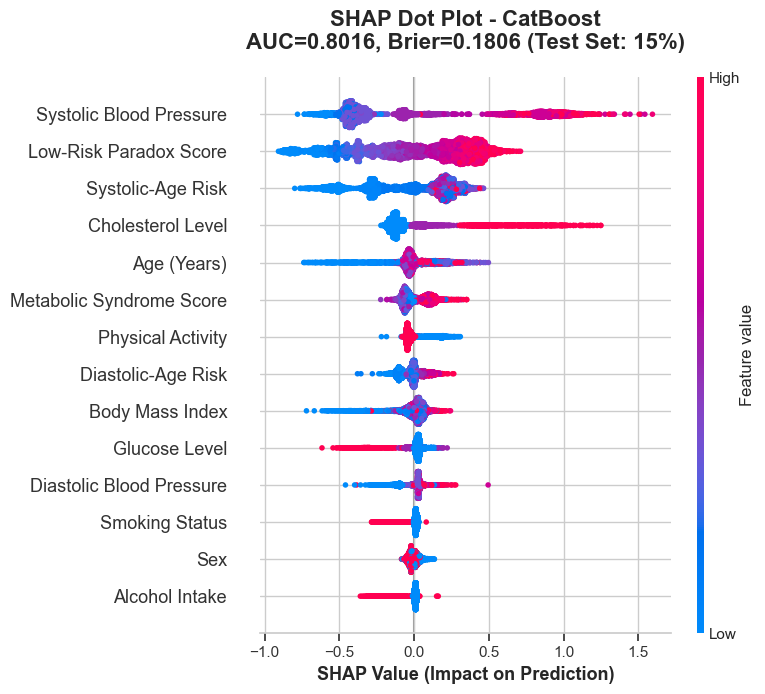


SHAP DOT PLOT COMPLETE
Model:        CatBoost + beta
Data Split:   70% train | 15% cal | 15% test
Sample Size:  6,000
Test AUC:     0.8016
Test Brier:   0.1806
Output:       P:\projects\heart_disease_prediction\reports\modeling\figures\04_shap_dot_plot.png



In [9]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except ImportError:
    pass

print("\n" + "="*80)
print("SHAP DOT PLOT ANALYSIS")
print("="*80)

SAMPLE_SIZE = 6000
RANDOM_STATE = 42

FEATURE_NAME_MAPPING = {
    'Sex': 'Sex',
    'Smoking_Status': 'Smoking Status',
    'Alcohol_Intake': 'Alcohol Intake',
    'Physical_Activity': 'Physical Activity',
    'Cholesterol_Level': 'Cholesterol Level',
    'Glucose_Level': 'Glucose Level',
    'Systolic_BP': 'Systolic Blood Pressure',
    'Diastolic_BP': 'Diastolic Blood Pressure',
    'Age_Years': 'Age (Years)',
    'BMI': 'Body Mass Index',
    'Systolic_Age_risk': 'Systolic-Age Risk',
    'Diastolic_Age_risk': 'Diastolic-Age Risk',
    'Metabolic_Syndrome_Score': 'Metabolic Syndrome Score',
    'Low_Risk_Paradox_Score': 'Low-Risk Paradox Score',
}

def get_project_root() -> Path:
    current = Path.cwd().resolve()
    max_depth = 5
    depth = 0
    
    while depth < max_depth and current != current.parent:
        if (current / 'artifacts').exists():
            return current
        current = current.parent
        depth += 1
    
    raise RuntimeError("Could not find project root")

if __name__ == "__main__":
    PROJECT_ROOT = get_project_root()
    ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
    DATA_DIR = ARTIFACTS_DIR / 'split data sets'
    MODEL_DIR = ARTIFACTS_DIR / 'model'
    REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
    FIGURES_DIR = REPORTS_DIR / 'figures'
    
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)
    
    print("\nLoading model package...")
    package = joblib.load(MODEL_DIR / 'model_package.pkl')
    
    model = package['base_model']
    calibrator = package.get('calibrator', None)
    threshold = package['threshold']
    performance = package.get('test_performance', {})
    model_type = package.get('model_type', 'Unknown')
    calibration_method = package.get('calibration_method', 'None')
    
    print(f"✓ Model: {model_type} + {calibration_method} Calibration")
    print(f"✓ Threshold: {threshold:.4f}")
    
    print("\nLoading test data (15%)...")
    # Load the full test set (30% of total data)
    X_test_full = pd.read_parquet(DATA_DIR / 'X_test.parquet')
    y_test_full = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0].values
    
    # ✅ Split into cal (15%) + test (15%) - matching training script
    X_cal, X_test, y_cal, y_test = train_test_split(
        X_test_full, y_test_full, test_size=0.5, 
        stratify=y_test_full, random_state=RANDOM_STATE
    )
    
    print(f"✓ Test set: {X_test.shape} (15% of total)")
    print(f"✓ Disease prevalence: {y_test.mean():.1%}")
    
    print("\nEvaluating model on test set...")
    y_test_prob_base = model.predict_proba(X_test)[:, 1]
    
    # ✅ Apply calibration if available
    if calibrator:
        if calibration_method == 'beta':
            try:
                from betacal import BetaCalibration
                y_test_prob = calibrator.predict(y_test_prob_base)
            except:
                y_test_prob = y_test_prob_base
        elif calibration_method == 'isotonic':
            y_test_prob = calibrator.predict(y_test_prob_base)
        else:
            y_test_prob = y_test_prob_base
    else:
        y_test_prob = y_test_prob_base
    
    brier = brier_score_loss(y_test, y_test_prob)
    auc = roc_auc_score(y_test, y_test_prob)
    
    print(f"  Test AUC:   {auc:.4f}")
    print(f"  Test Brier: {brier:.4f}")
    
    print(f"\nSubsampling for SHAP (target: {SAMPLE_SIZE})...")
    if len(X_test) > SAMPLE_SIZE:
        sample_indices = np.random.RandomState(RANDOM_STATE).choice(
            len(X_test), size=SAMPLE_SIZE, replace=False
        )
        X_sample = X_test.iloc[sample_indices]
    else:
        X_sample = X_test.copy()
    
    X_sample = X_sample.astype('float32')
    print(f"✓ SHAP sample: {X_sample.shape}")
    
    print("\nComputing SHAP values...")
    print("  (This may take a few minutes...)")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    
    # Handle different SHAP output formats
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Binary classification
    elif len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]  # Multi-output
    
    print(f"✓ SHAP values shape: {shap_values.shape}")
    
    # Rename columns for better visualization
    rename_dict = {col: FEATURE_NAME_MAPPING.get(col, col) for col in X_sample.columns}
    X_sample_renamed = X_sample.rename(columns=rename_dict)
    
    print("\nCreating SHAP dot plot...")
    
    # Create figure
    plt.figure(figsize=(14, 11))
    
    # SHAP summary plot (dot plot)
    shap.summary_plot(
        shap_values,
        X_sample_renamed,
        plot_type='dot',
        max_display=20,
        show=False
    )
    
    # Add title
    title = f'SHAP Dot Plot - {model_type}\n'
    title += f'AUC={auc:.4f}, Brier={brier:.4f} (Test Set: 15%)'
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Customize x-label
    plt.xlabel('SHAP Value (Impact on Prediction)', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    
    output_path = FIGURES_DIR / '04_shap_dot_plot.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Saved: {output_path.name}")
    plt.show()
    plt.close()
    
    print("\n" + "="*80)
    print("SHAP DOT PLOT COMPLETE")
    print("="*80)
    print(f"Model:        {model_type} + {calibration_method}")
    print(f"Data Split:   70% train | 15% cal | 15% test")
    print(f"Sample Size:  {X_sample.shape[0]:,}")
    print(f"Test AUC:     {auc:.4f}")
    print(f"Test Brier:   {brier:.4f}")
    print(f"Output:       {output_path}")
    print("="*80 + "\n")

### SHAP Waterfall Plot: Individual Patient Risk Explanation


INDIVIDUAL PATIENT SHAP ANALYSIS

Loading model package...
✓ Model: CatBoost + beta

Loading test data (15%)...
✓ Test set: (10497, 14) (15% of total)

Getting predictions...

Subsampling for SHAP (target: 6000)...
✓ SHAP sample: (6000, 14)

Computing SHAP values...
  (This may take a few minutes...)

Selecting random patient...
  Risk score: 0.5702
  Ground truth: Healthy
  Prediction: Disease
  Risk group: High

Creating visualization...
✅ Saved: 05_individual_patient_shap_analysis.png


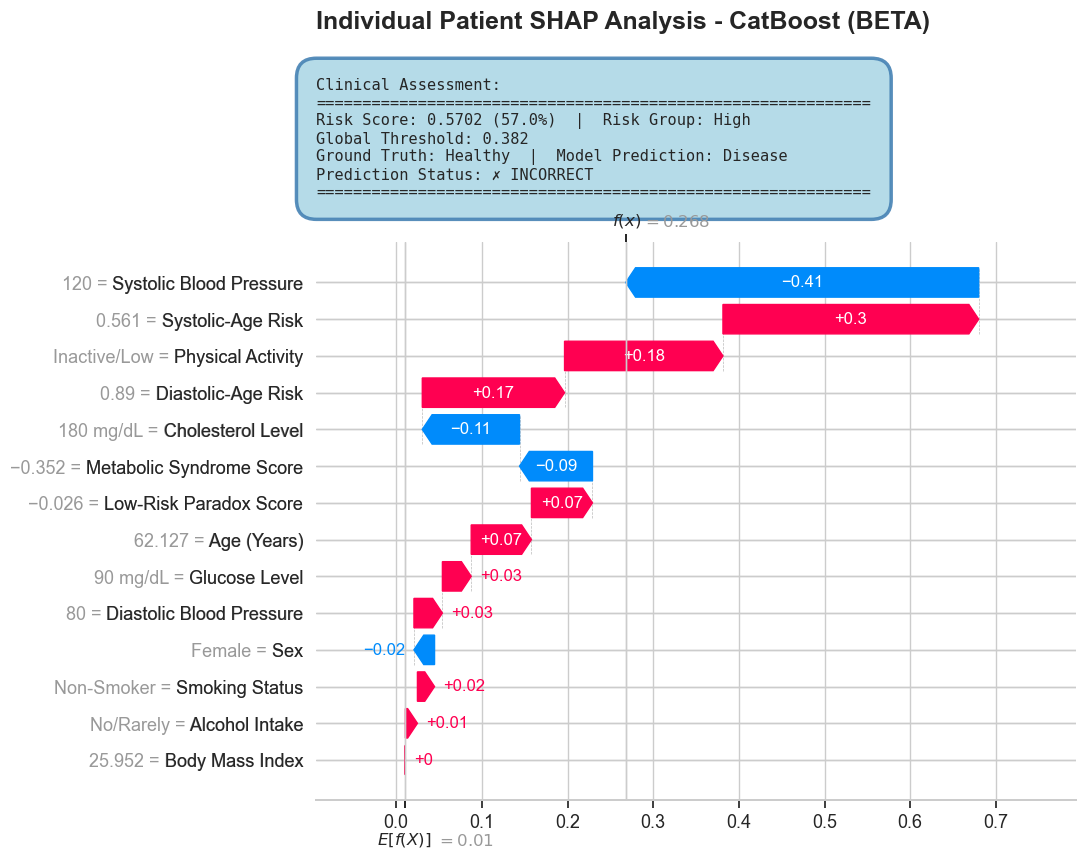


INDIVIDUAL PATIENT ANALYSIS COMPLETE
Data Split:        70% train | 15% cal | 15% test
Patient ID:        860
Risk Score:        0.5702
Risk Group:        High
Ground Truth:      Healthy
Prediction:        Disease
Output:            P:\projects\heart_disease_prediction\reports\modeling\figures\05_individual_patient_shap_analysis.png



In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*80)
print("INDIVIDUAL PATIENT SHAP ANALYSIS")
print("="*80)

SAMPLE_SIZE = 6000
RANDOM_STATE = 42

FIGURE_WIDTH = 16
FIGURE_HEIGHT = 20
TITLE_FONTSIZE = 18
BOX_FONTSIZE = 11
OUTPUT_DPI = 300

FEATURE_NAME_MAPPING = {
    'Sex': 'Sex',
    'Smoking_Status': 'Smoking Status',
    'Alcohol_Intake': 'Alcohol Intake',
    'Physical_Activity': 'Physical Activity',
    'Cholesterol_Level': 'Cholesterol Level',
    'Glucose_Level': 'Glucose Level',
    'Systolic_BP': 'Systolic Blood Pressure',
    'Diastolic_BP': 'Diastolic Blood Pressure',
    'Age_Years': 'Age (Years)',
    'BMI': 'Body Mass Index',
    'Systolic_Age_risk': 'Systolic-Age Risk',
    'Diastolic_Age_risk': 'Diastolic-Age Risk',
    'Metabolic_Syndrome_Score': 'Metabolic Syndrome Score',
    'Low_Risk_Paradox_Score': 'Low-Risk Paradox Score',
}

VALUE_MAPPINGS = {
    'Sex': {0: 'Female', 1: 'Male'},
    'Smoking_Status': {0: 'Non-Smoker', 1: 'Smoker'},
    'Alcohol_Intake': {0: 'No/Rarely', 1: 'Yes/Regularly'},
    'Physical_Activity': {0: 'Inactive/Low', 1: 'Active'},
    'Cholesterol_Level': {0: '180 mg/dL', 1: '220 mg/dL', 2: '260 mg/dL'},
    'Glucose_Level': {0: '90 mg/dL', 1: '110 mg/dL', 2: '140 mg/dL'},
}

def get_project_root() -> Path:
    current = Path.cwd().resolve()
    max_depth = 5
    depth = 0
    
    while depth < max_depth and current != current.parent:
        if (current / 'artifacts').exists():
            return current
        current = current.parent
        depth += 1
    
    raise RuntimeError("Could not find project root")

if __name__ == "__main__":
    PROJECT_ROOT = get_project_root()
    ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
    DATA_DIR = ARTIFACTS_DIR / 'split data sets'
    MODEL_DIR = ARTIFACTS_DIR / 'model'
    REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
    FIGURES_DIR = REPORTS_DIR / 'figures'
    
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)
    
    print("\nLoading model package...")
    package = joblib.load(MODEL_DIR / 'model_package.pkl')
    
    base_model = package['base_model']
    calibrator = package.get('calibrator', None)
    calibration_method = package.get('calibration_method', 'base')
    model_type = package.get('model_type', 'Unknown')
    threshold = package['threshold']
    test_performance = package.get('test_performance', {})
    
    # ✅ Use saved leaf_to_risk mapping
    has_cart = 'cart_model' in package and 'leaf_to_risk' in package
    if has_cart:
        cart_model = package['cart_model']
        leaf_to_risk = package['leaf_to_risk']
        risk_stats = package.get('risk_statistics', {})
    
    print(f"✓ Model: {model_type} + {calibration_method}")
    
    print("\nLoading test data (15%)...")
    # Load full test set (30% of total)
    X_test_full = pd.read_parquet(DATA_DIR / 'X_test.parquet')
    y_test_full = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0].values
    
    # ✅ Split into cal (15%) + test (15%)
    X_cal, X_test, y_cal, y_test = train_test_split(
        X_test_full, y_test_full, test_size=0.5, 
        stratify=y_test_full, random_state=RANDOM_STATE
    )
    
    features = X_test.columns.tolist()
    print(f"✓ Test set: {X_test.shape} (15% of total)")
    
    print("\nGetting predictions...")
    y_test_prob_base = base_model.predict_proba(X_test)[:, 1]
    
    # ✅ Apply calibration
    if calibrator:
        if calibration_method == 'beta':
            try:
                from betacal import BetaCalibration
                y_test_prob = calibrator.predict(y_test_prob_base)
            except:
                y_test_prob = y_test_prob_base
        elif calibration_method == 'isotonic':
            y_test_prob = calibrator.predict(y_test_prob_base)
        else:
            y_test_prob = y_test_prob_base
    else:
        y_test_prob = y_test_prob_base
    
    y_pred = (y_test_prob >= threshold).astype(int)
    
    print(f"\nSubsampling for SHAP (target: {SAMPLE_SIZE})...")
    if len(X_test) > SAMPLE_SIZE:
        sample_indices = np.random.RandomState(RANDOM_STATE).choice(
            len(X_test), size=SAMPLE_SIZE, replace=False
        )
        X_sample = X_test.iloc[sample_indices]
        y_sample = y_test[sample_indices]
        selected_proba = y_test_prob[sample_indices]
    else:
        X_sample = X_test.copy()
        y_sample = y_test.copy()
        selected_proba = y_test_prob.copy()
    
    X_sample = X_sample.astype('float32')
    print(f"✓ SHAP sample: {X_sample.shape}")
    
    print("\nComputing SHAP values...")
    print("  (This may take a few minutes...)")
    explainer = shap.TreeExplainer(base_model)
    shap_values = explainer.shap_values(X_sample)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    elif len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]
    
    print("\nSelecting random patient...")
    np.random.seed(RANDOM_STATE)
    patient_idx = np.random.randint(0, len(X_sample))
    
    patient_data = X_sample.iloc[patient_idx:patient_idx+1].copy()
    patient_prob = selected_proba[patient_idx]
    patient_shap = shap_values[patient_idx]
    y_pred_patient = (patient_prob >= threshold).astype(int)
    y_true_patient = y_sample[patient_idx]
    
    actual_label = 'Disease' if y_true_patient == 1 else 'Healthy'
    predicted_label = 'Disease' if y_pred_patient == 1 else 'Healthy'
    is_correct = (y_pred_patient == y_true_patient)
    
    print(f"  Risk score: {patient_prob:.4f}")
    print(f"  Ground truth: {actual_label}")
    print(f"  Prediction: {predicted_label}")
    
    # ✅ Get risk group using saved mapping
    risk_group = None
    if has_cart:
        X_cart = pd.DataFrame({'Predicted_Risk': [patient_prob]})
        leaf = cart_model.apply(X_cart)[0]
        risk_group = leaf_to_risk.get(leaf, 'Unknown')
        print(f"  Risk group: {risk_group}")
    
    # Apply value mappings
    patient_data_display = patient_data.copy()
    for feature in features:
        if feature in VALUE_MAPPINGS:
            original_value = patient_data.iloc[0][feature]
            if original_value in VALUE_MAPPINGS[feature]:
                patient_data_display.loc[patient_data_display.index[0], feature] = \
                    VALUE_MAPPINGS[feature][original_value]
    
    # Get base value
    def get_base_value_safe(explainer, X_data):
        if not hasattr(explainer, 'expected_value'):
            return float(np.mean(base_model.predict_proba(X_data)[:, 1]))
        
        expected_val = explainer.expected_value
        
        if isinstance(expected_val, (int, float, np.integer, np.floating)):
            return float(expected_val)
        
        if isinstance(expected_val, (list, np.ndarray)):
            expected_val = np.array(expected_val) if isinstance(expected_val, list) else expected_val
            if expected_val.ndim == 0:
                return float(expected_val.item())
            elif expected_val.ndim == 1:
                return float(expected_val[1] if len(expected_val) > 1 else expected_val[0])
        
        return float(np.mean(base_model.predict_proba(X_data)[:, 1]))
    
    base_value = get_base_value_safe(explainer, X_sample)
    
    # Create SHAP explanation
    feature_display_names = [FEATURE_NAME_MAPPING.get(f, f) for f in features]
    
    shap_exp = shap.Explanation(
        values=patient_shap,
        base_values=base_value,
        data=patient_data_display.values[0],
        feature_names=feature_display_names
    )
    
    print("\nCreating visualization...")
    
    # Create figure
    fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    gs = gridspec.GridSpec(24, 1, figure=fig, hspace=0.3)
    
    # Title
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.axis('off')
    title_text = f'Individual Patient SHAP Analysis - {model_type}'
    if calibration_method != 'base':
        title_text += f' ({calibration_method.upper()})'
    ax0.text(0.0, 0.5, title_text, fontsize=TITLE_FONTSIZE, fontweight='bold', 
             ha='left', va='center', transform=ax0.transAxes)
    
    # Clinical assessment
    ax1 = fig.add_subplot(gs[2:6, 0])
    ax1.axis('off')
    
    clinical_text = f"""Clinical Assessment:
{"="*60}
Risk Score: {patient_prob:.4f} ({patient_prob*100:.1f}%)"""
    
    if has_cart and risk_group:
        clinical_text += f"  |  Risk Group: {risk_group}"
    
    clinical_text += f"""
Global Threshold: {threshold:.3f}
Ground Truth: {actual_label}  |  Model Prediction: {predicted_label}
Prediction Status: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}
{"="*60}"""
    
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.9,
                 edgecolor='steelblue', linewidth=2.5, pad=1.3)
    
    ax1.text(0.0, 0.5, clinical_text, fontsize=BOX_FONTSIZE, ha='left', va='center',
             bbox=props, family='monospace', transform=ax1.transAxes)
    
    # SHAP waterfall
    ax2 = fig.add_subplot(gs[7:, 0])
    plt.sca(ax2)
    shap.plots.waterfall(shap_exp, max_display=len(shap_exp.values), show=False)
    
    fig.subplots_adjust(top=0.97, bottom=0.04, left=0.03, right=0.98, hspace=0.3)
    
    output_path = FIGURES_DIR / '05_individual_patient_shap_analysis.png'
    plt.savefig(output_path, dpi=OUTPUT_DPI, bbox_inches='tight', pad_inches=0.3)
    print(f"✅ Saved: {output_path.name}")
    plt.show()
    plt.close()
    
    print(f"\n{'='*80}")
    print("INDIVIDUAL PATIENT ANALYSIS COMPLETE")
    print(f"{'='*80}")
    print(f"Data Split:        70% train | 15% cal | 15% test")
    print(f"Patient ID:        {patient_idx}")
    print(f"Risk Score:        {patient_prob:.4f}")
    if has_cart and risk_group:
        print(f"Risk Group:        {risk_group}")
    print(f"Ground Truth:      {actual_label}")
    print(f"Prediction:        {predicted_label}")
    print(f"Output:            {output_path}")
    print(f"{'='*80}\n")


DECISION CURVE ANALYSIS

Loading model and data...
✓ Model: CatBoost + beta with 3 risk groups
✓ Threshold: 0.3818

Loading test data (15%)...
✓ Test set: 10,497 patients (15% of total)
✓ Prevalence: 50.0%

Computing Decision Curve Analysis...
✓ Net Benefit at 0.3818: 0.2921

Creating visualization...
✅ Saved: 06_decision_curve_analysis.png


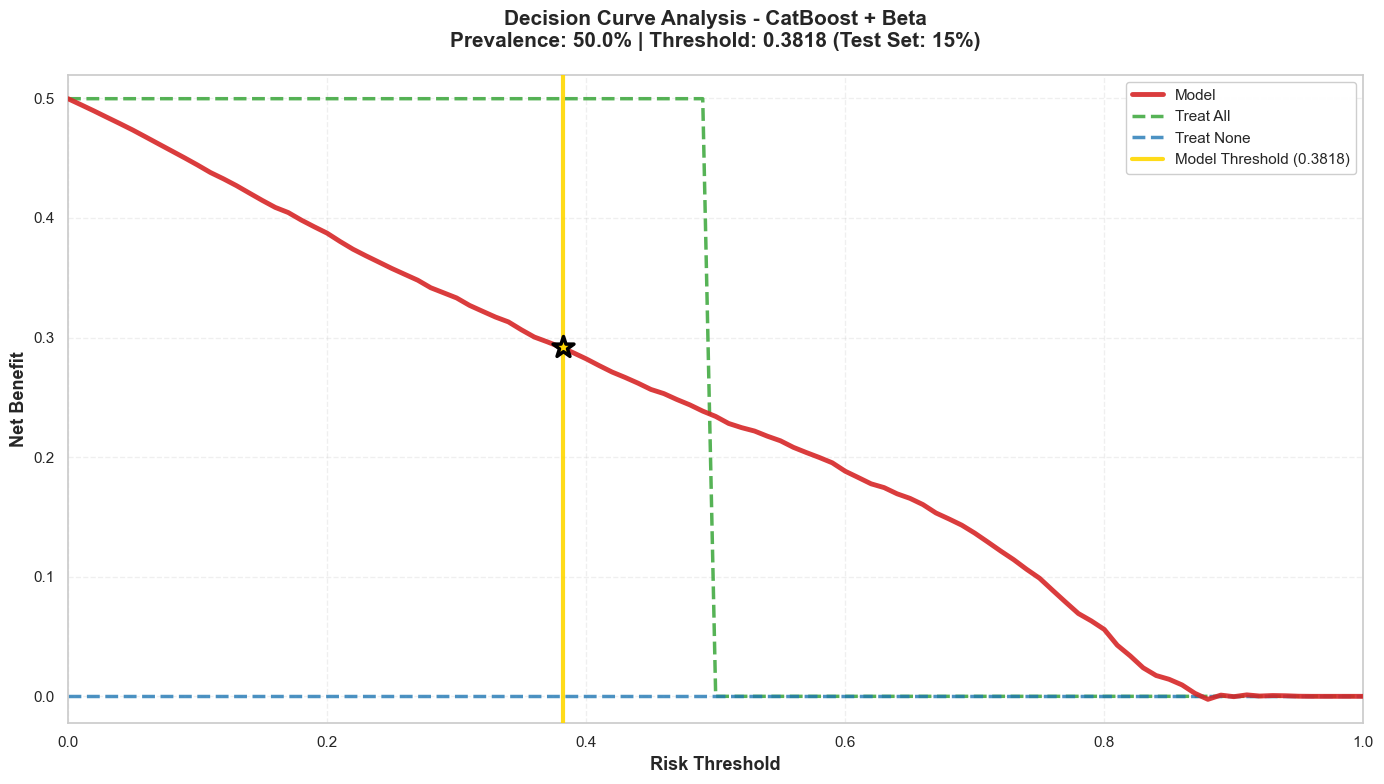


Generating summary...

DECISION CURVE ANALYSIS RESULTS

Data Split: 70% train | 15% cal | 15% test
Model: CatBoost + beta

Net Benefit at threshold 0.3818: 0.2921
Treat All net benefit: 0.4998
Improvement: -0.2076

⚠️  Model net benefit ≤ treating all patients
   Threshold optimized for minimum sensitivity (0.80)

💾 Saved: dca_summary.json
💾 Saved: 06_decision_curve_analysis.png



In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import json
import warnings
warnings.filterwarnings('ignore')

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except ImportError:
    pass

def get_project_root() -> Path:
    current = Path.cwd().resolve()
    max_depth = 5
    depth = 0
    
    while depth < max_depth and current != current.parent:
        if (current / 'artifacts').exists():
            return current
        current = current.parent
        depth += 1
    
    raise RuntimeError("Could not find project root")

if __name__ == "__main__":
    PROJECT_ROOT = get_project_root()
    ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
    DATA_DIR = ARTIFACTS_DIR / 'split data sets'
    MODEL_DIR = ARTIFACTS_DIR / 'model'
    REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
    METRICS_DIR = REPORTS_DIR / 'metrics'
    FIGURES_DIR = REPORTS_DIR / 'figures'
    
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)
    METRICS_DIR.mkdir(parents=True, exist_ok=True)
    
    print("\n" + "="*80)
    print("DECISION CURVE ANALYSIS")
    print("="*80)
    
    print("\nLoading model and data...")
    package = joblib.load(MODEL_DIR / 'model_package.pkl')
    
    model = package['base_model']
    calibrator = package.get('calibrator', None)
    calibration_method = package.get('calibration_method', 'None')
    model_type = package.get('model_type', 'Unknown')
    model_threshold = package['threshold']
    
    has_cart = 'cart_model' in package and 'risk_statistics' in package
    if has_cart:
        risk_stats = package['risk_statistics']
        print(f"✓ Model: {model_type} + {calibration_method} with {len(risk_stats)} risk groups")
    else:
        print(f"✓ Model: {model_type} + {calibration_method}")
    
    print(f"✓ Threshold: {model_threshold:.4f}")
    
    print("\nLoading test data (15%)...")
    # Load full test set (30% of total)
    X_test_full = pd.read_parquet(DATA_DIR / 'X_test.parquet')
    y_test_full = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0].values
    
    # ✅ Split into cal (15%) + test (15%)
    X_cal, X_test, y_cal, y_test = train_test_split(
        X_test_full, y_test_full, test_size=0.5, 
        stratify=y_test_full, random_state=42
    )
    
    # ✅ Get predictions with calibration
    y_proba_base = model.predict_proba(X_test)[:, 1]
    
    if calibrator:
        if calibration_method == 'beta':
            try:
                from betacal import BetaCalibration
                y_proba = calibrator.predict(y_proba_base)
            except:
                y_proba = y_proba_base
        elif calibration_method == 'isotonic':
            y_proba = calibrator.predict(y_proba_base)
        else:
            y_proba = y_proba_base
    else:
        y_proba = y_proba_base
    
    n_total = len(y_test)
    prevalence = y_test.mean()
    
    print(f"✓ Test set: {n_total:,} patients (15% of total)")
    print(f"✓ Prevalence: {prevalence*100:.1f}%")
    
    print("\nComputing Decision Curve Analysis...")
    
    def calculate_net_benefit(y_true, y_proba, threshold):
        """Calculate net benefit for a given threshold."""
        if threshold == 0:
            return prevalence  # Treat all
        if threshold == 1:
            return 0.0  # Treat none
        
        y_pred = (y_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Net benefit = (TP/N) - (FP/N) * (pt/(1-pt))
        cost_ratio = threshold / (1 - threshold)
        net_benefit = (tp / n_total) - (fp / n_total) * cost_ratio
        
        return net_benefit
    
    # Calculate for range of thresholds
    threshold_range = np.arange(0.0, 1.01, 0.01)
    net_benefit_model = [calculate_net_benefit(y_test, y_proba, t) for t in threshold_range]
    net_benefit_treat_all = [prevalence if t <= prevalence else 0 for t in threshold_range]
    net_benefit_treat_none = np.zeros_like(threshold_range)
    
    # Get net benefit at model's threshold
    model_idx = np.argmin(np.abs(threshold_range - model_threshold))
    net_benefit_at_threshold = net_benefit_model[model_idx]
    
    print(f"✓ Net Benefit at {model_threshold:.4f}: {net_benefit_at_threshold:.4f}")
    
    print("\nCreating visualization...")
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot curves
    ax.plot(threshold_range, net_benefit_model, label='Model', lw=3.5,
            color='#d62728', linestyle='-', alpha=0.9, zorder=3)
    ax.plot(threshold_range, net_benefit_treat_all, label='Treat All', lw=2.5,
            color='#2ca02c', linestyle='--', alpha=0.8, zorder=2)
    ax.plot(threshold_range, net_benefit_treat_none, label='Treat None', lw=2.5,
            color='#1f77b4', linestyle='--', alpha=0.8, zorder=2)
    
    # Mark model threshold
    ax.axvline(model_threshold, color='gold', linestyle='-', lw=3, alpha=0.9,
               label=f'Model Threshold ({model_threshold:.4f})', zorder=4)
    ax.scatter([model_threshold], [net_benefit_at_threshold], color='gold', s=250,
               zorder=5, edgecolor='black', linewidth=2.5, marker='*')
    
    ax.set_xlabel('Risk Threshold', fontsize=13, fontweight='bold')
    ax.set_ylabel('Net Benefit', fontsize=13, fontweight='bold')
    
    title = f'Decision Curve Analysis - {model_type} + {calibration_method.title()}\n'
    title += f'Prevalence: {prevalence*100:.1f}% | Threshold: {model_threshold:.4f} (Test Set: 15%)'
    ax.set_title(title, fontsize=15, fontweight='bold', pad=20)
    
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=11, loc='upper right', framealpha=0.95)
    ax.set_xlim([0, 1])
    
    y_min = min(0, min(net_benefit_model)) - 0.02
    y_max = max(prevalence, max(net_benefit_model)) + 0.02
    ax.set_ylim([y_min, y_max])
    
    plt.tight_layout()
    output_path = FIGURES_DIR / '06_decision_curve_analysis.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Saved: {output_path.name}")
    plt.show()
    plt.close()
    
    print("\nGenerating summary...")
    
    improvement_vs_treat_all = net_benefit_at_threshold - prevalence
    
    print("\n" + "="*80)
    print("DECISION CURVE ANALYSIS RESULTS")
    print("="*80)
    print(f"\nData Split: 70% train | 15% cal | 15% test")
    print(f"Model: {model_type} + {calibration_method}")
    print(f"\nNet Benefit at threshold {model_threshold:.4f}: {net_benefit_at_threshold:.4f}")
    print(f"Treat All net benefit: {prevalence:.4f}")
    print(f"Improvement: {improvement_vs_treat_all:+.4f}")
    
    if improvement_vs_treat_all > 0:
        print(f"\n✅ Model provides positive net benefit")
        print(f"   Model is clinically useful for decision-making")
    else:
        print(f"\n⚠️  Model net benefit ≤ treating all patients")
        print(f"   Threshold optimized for minimum sensitivity (0.80)")
    
    # Save summary
    dca_summary = {
        'model_type': model_type,
        'calibration_method': calibration_method,
        'threshold': float(model_threshold),
        'data_split': {
            'train_pct': 70.0,
            'cal_pct': 15.0,
            'test_pct': 15.0,
            'n_test': int(n_total)
        },
        'prevalence': float(prevalence),
        'net_benefit_at_threshold': float(net_benefit_at_threshold),
        'net_benefit_treat_all': float(prevalence),
        'improvement': float(improvement_vs_treat_all),
        'is_useful': bool(improvement_vs_treat_all > 0)
    }
    
    with open(METRICS_DIR / 'dca_summary.json', 'w') as f:
        json.dump(dca_summary, f, indent=2)
    
    print(f"\n💾 Saved: dca_summary.json")
    print(f"💾 Saved: {output_path.name}")
    print("="*80 + "\n")